In [ ]:
# mount drive with files

from google.colab import drive
drive.mount('/content/drive')

!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
# import libraries

import os
import shutil
import tempfile
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    RandGaussianSmoothd,
    RandAffined,
    ToTensord,
    RandGibbsNoised,
)



from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import AttentionUnet

from monai.data import (
    DataLoader,
    SmartCacheDataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# switch off warning messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set dimensions of the input images (160x160x160) and number of classes (number of labels + background)
img_dim=128
lab_num=1
class_num=lab_num+1


degree_min = -1
degree_max = 1

roi_type="face_"

split_JSON = "face-training-1-lab-v1.json"
split_JSON_run = "face-training-1-lab-v1.json"



root_dir='/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'
data_dir = '/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'

print(root_dir)
os.chdir(root_dir)

/content/drive/MyDrive/face-seg-project-2023/new-training-062023/


In [ ]:
# define data loaders and augmentation for training and validation

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),

        RandGaussianSmoothd(keys=["image"], sigma_x = (0.7, 1.0), sigma_y = (0.7, 1.0), sigma_z = (0.7, 1.0), prob=0.1, allow_missing_keys=False),

        RandKSpaceSpikeNoised(keys=["image"], prob=0.3, intensity_range=(1.0, 1.5), allow_missing_keys=False),

        RandGibbsNoised(keys=["image"], alpha=(0.3,0.5), allow_missing_keys=False, prob=0.05),

        RandAffined(
            keys=["image", "label"],
            rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"),
            prob=0.9,
        ),
        ToTensord(keys=["image", "label"]),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
        ToTensord(keys=["image", "label"]),
    ]
)




In [ ]:
# load the files based on the lists in .json (it should be located in your data folder)

datasets = data_dir + split_JSON

datalist = load_decathlon_datalist(datasets, True, "training")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=200,
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_num=80,
    cache_rate=1.0,
    num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)



Loading dataset: 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


82
torch.Size([1, 128, 128, 128])
0 303-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


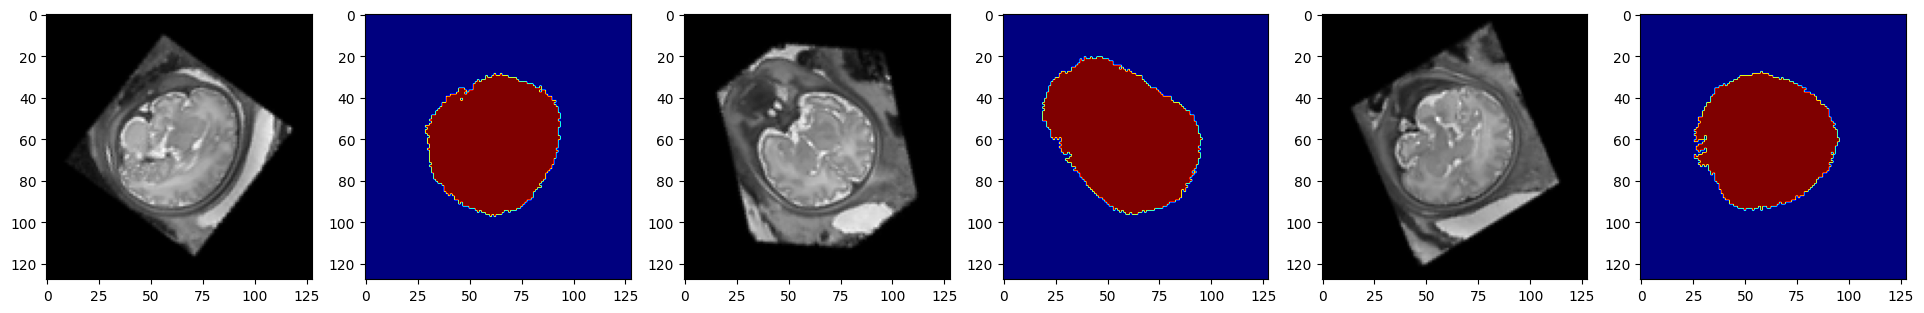

In [ ]:

s=round(img_dim/2)

print(len(datalist))

for x in range(len(datalist)):
  case_num = x
  img_name = datalist[case_num]["label"]
  label_name = datalist[case_num]["label"]
  case_name = os.path.split(train_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=train_ds[case_num]
  img = case_in["image"]
  print(img.shape)
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))

  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")

  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")

  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")

  plt.show()

  break


0 261-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


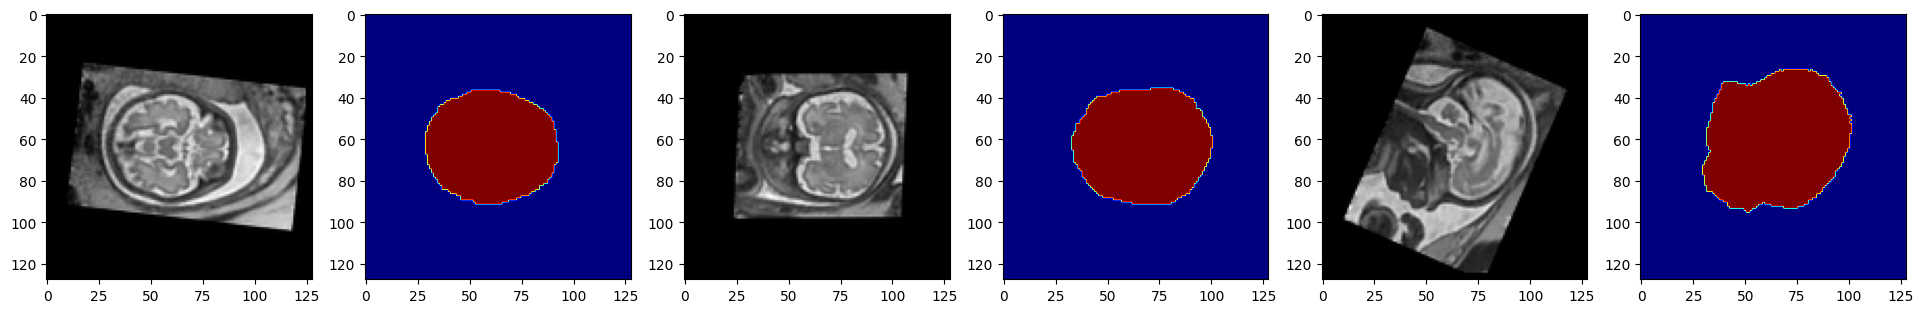

1 335-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


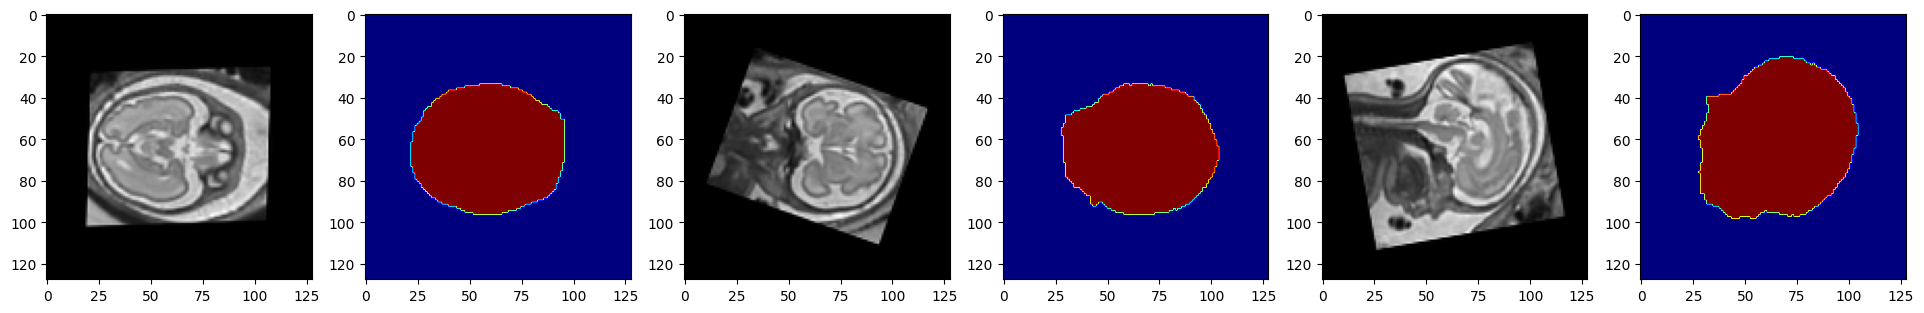

2 426-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


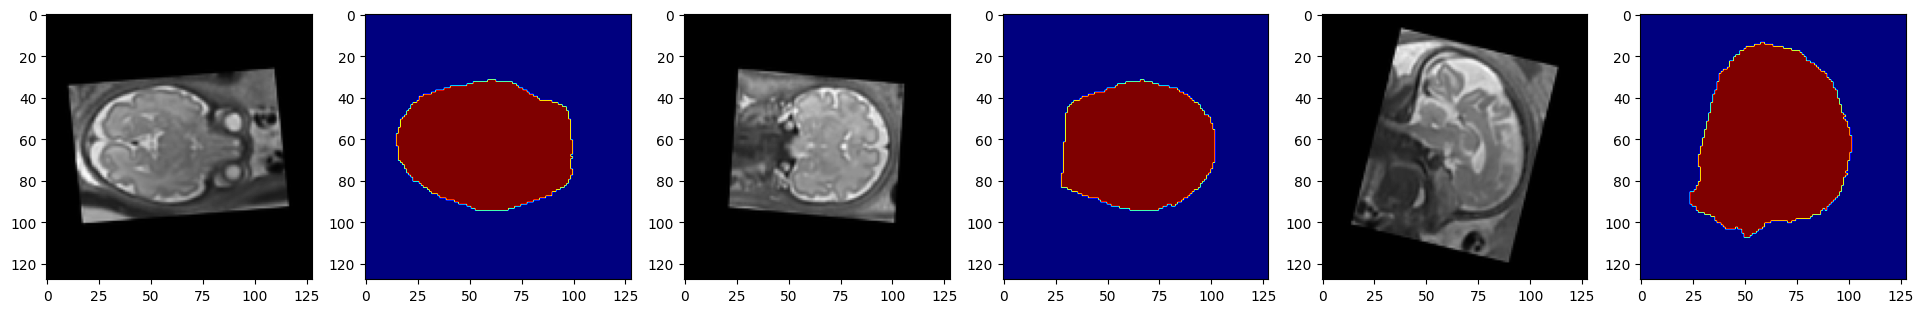

3 342-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


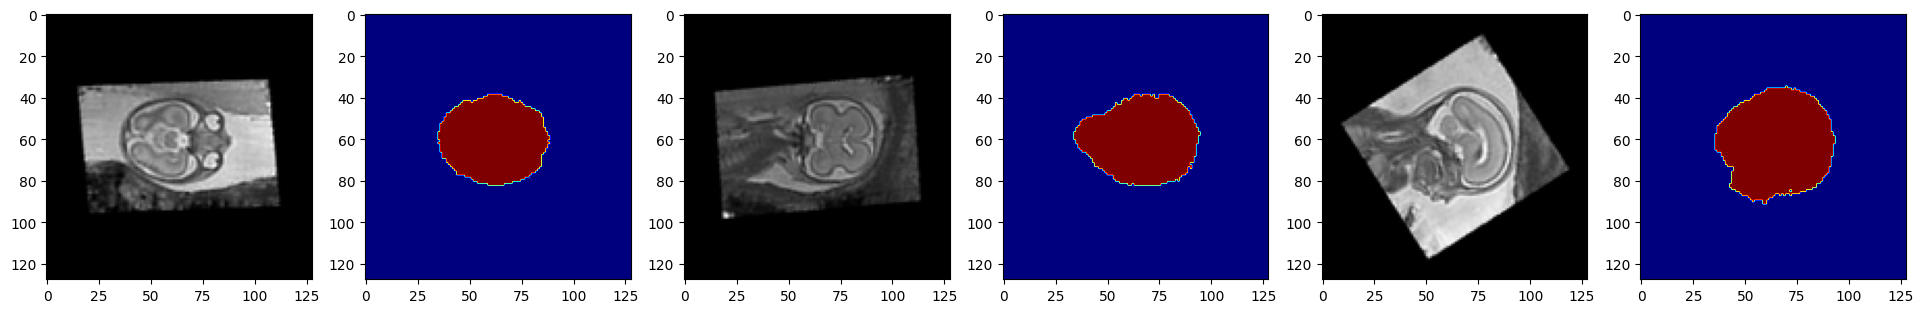

4 435-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


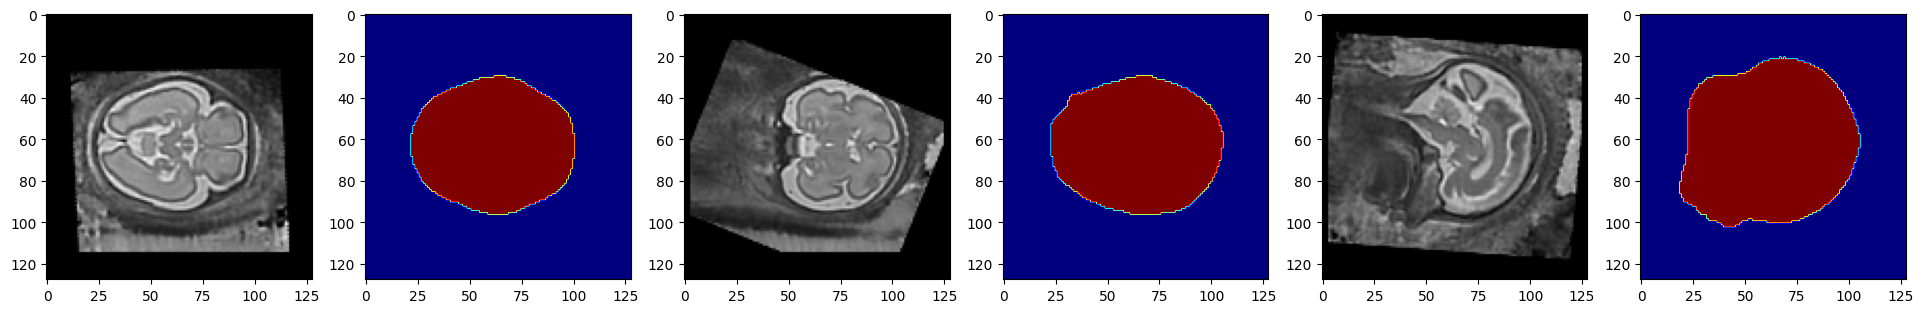

5 hist-136-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


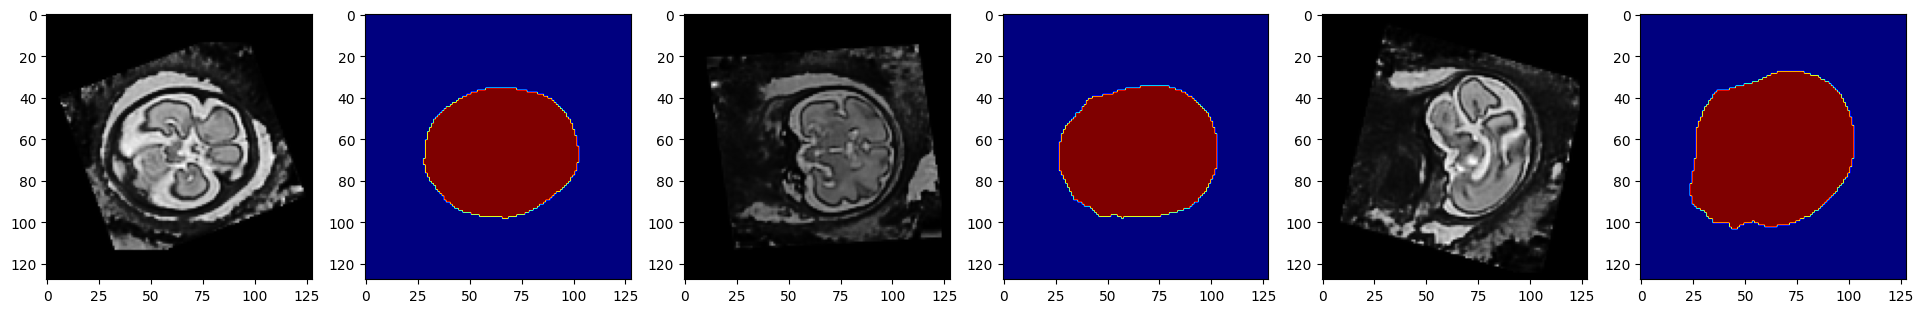

6 hist-214-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


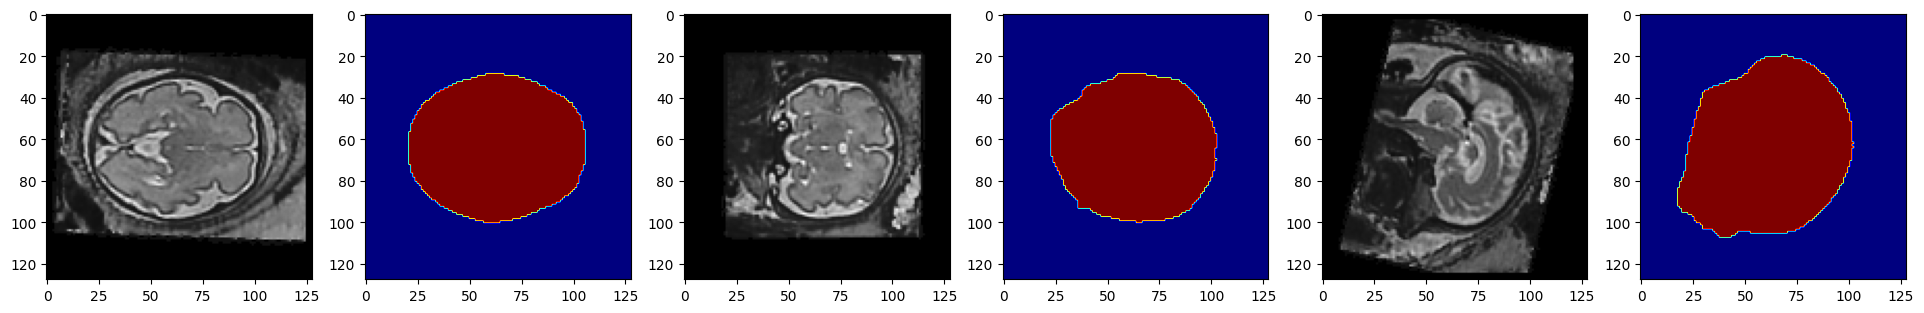

7 hist-236-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


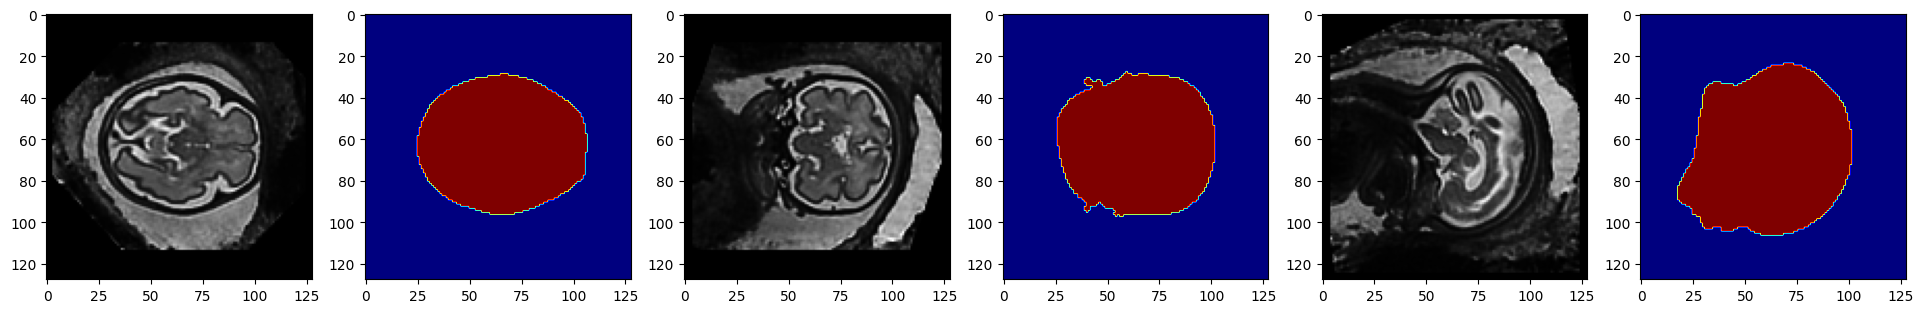

8 hist-253-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


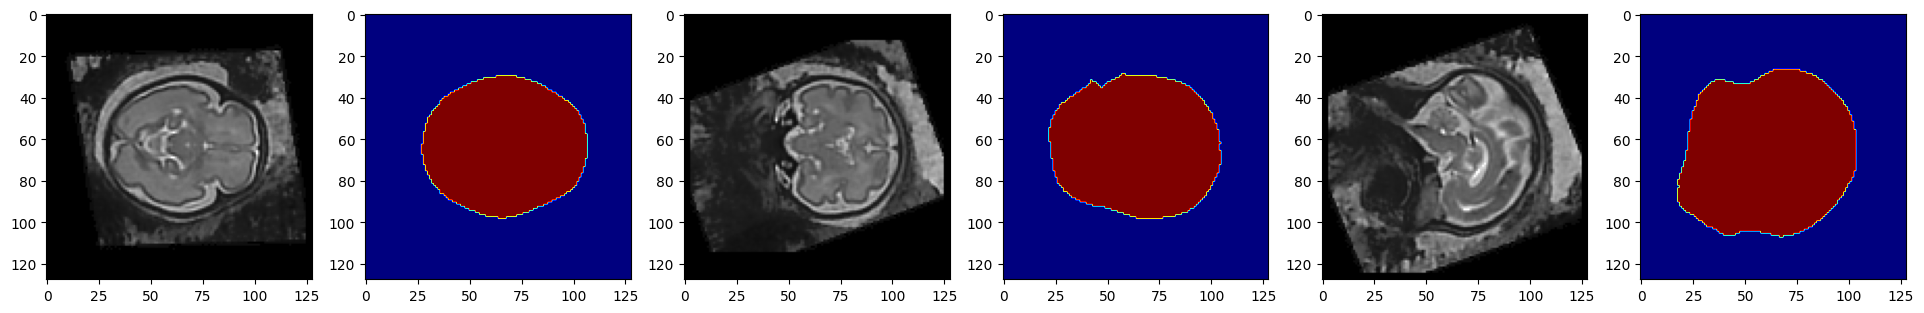

9 hist-275-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


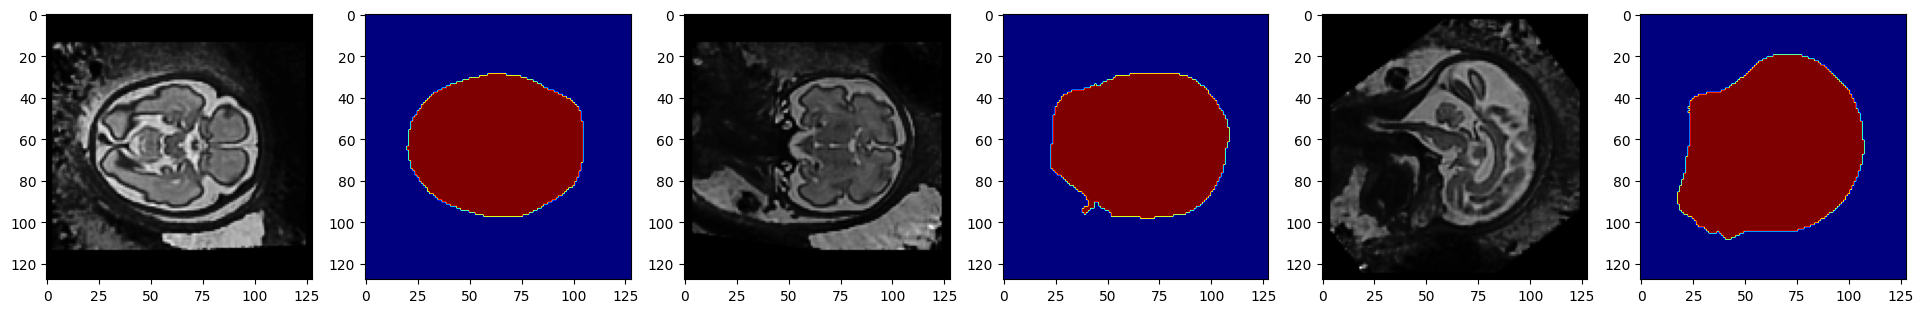

10 hist-292-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


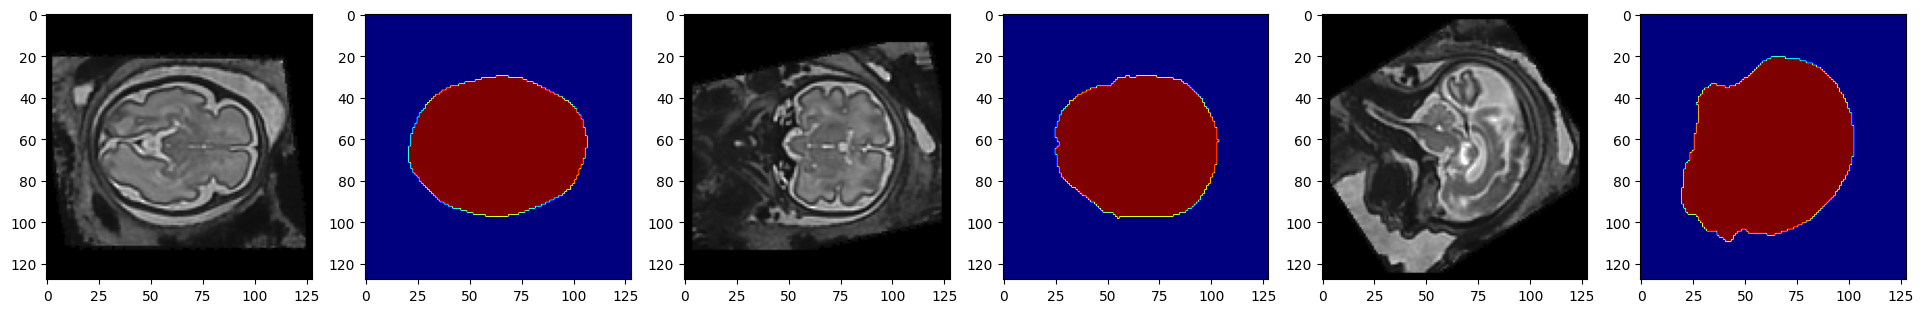

11 hist-355-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


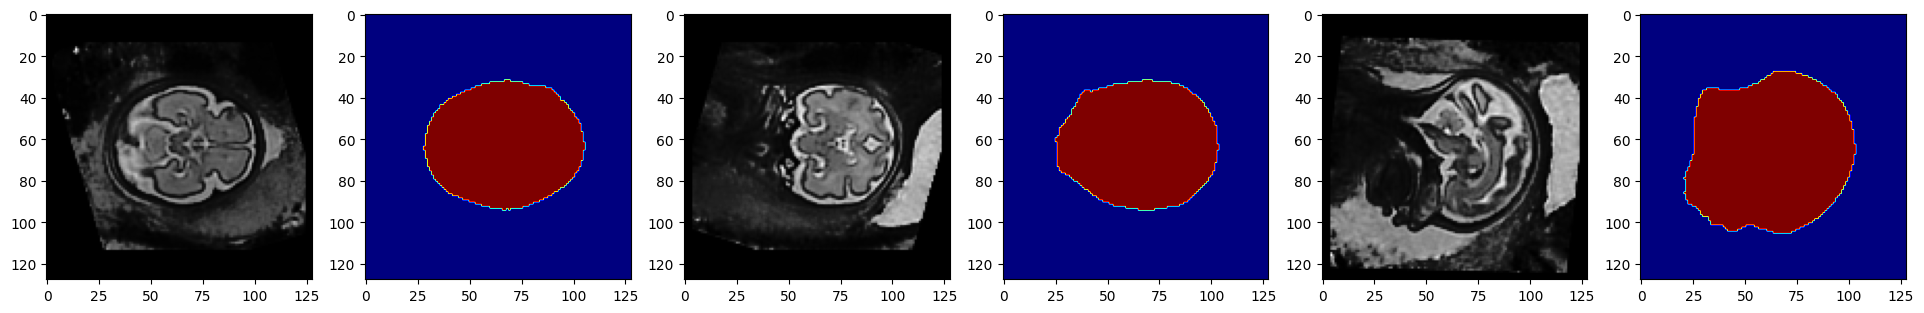

In [ ]:

s=round(img_dim/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["label"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()


In [ ]:

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

spatial_dims = 3
in_channels = 1
out_channels = class_num
channels = [32, 64, 128, 256, 512]
strides = [2, 2, 2, 2]
kernel_size = 3
up_kernel_size = 3
dropout = 0.0

model = AttentionUnet(
    spatial_dims=spatial_dims,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    kernel_size=kernel_size,
    up_kernel_size=up_kernel_size,
    dropout=dropout,
).to(device)


loss_function =  DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement):
    model.train()
    epoch_loss = 0
    step = 0
    total_training_time = 0
    patience = 10
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    # Initialize variables for early stopping
    start_time = time.time()  # Record the start time
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        # Check if early stopping condition is met
        if epochs_without_improvement >= patience:
          print("Early stopping: Model has not improved for {} epochs.".format(patience))
          epoch_iterator.close()
          epoch_iterator_val.close()
          break

        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            #CHANGE PER MODEL
            epoch_loss_values_att_unet_withaug.append(epoch_loss)
            #CHANGE PER MODEL
            metric_values_att_unet_withaug.append(dice_val)

            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                epochs_without_improvement = 0 # Reset patience counter
                print("Patience Counter has Been Reset")
                #CHANGE PER MODEL
                torch.save(
                    model.state_dict(), os.path.join(root_dir, (roi_type+"att_unet_withaug_best_metric_model.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                print("Epochs Without Improvement:{}".format(epochs_without_improvement))

            else:
              epochs_without_improvement += 1
              #CHANGE PER MODEL
              torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"att_unet_withaug_latest_metric_model.pth")))
              print("Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
              print("+1 Added to Patience Counter")
              print("Epochs Without Improvement:{}".format(epochs_without_improvement))



        global_step += 1

    # Training loop has completed, calculate the total training time
    end_time = time.time()
    epoch_iterator.close()

    total_training_time += end_time - start_time
    total_training_time_minutes = total_training_time / 60
    print(f"\nTotal Training Time: {total_training_time_minutes:.2f} minutes")
    print(f"Global step: {global_step}, Eval num: {eval_num}, Max iterations: {max_iterations}")
    return global_step, dice_val_best, global_step_best, epochs_without_improvement





In [ ]:
max_iterations = 30000
eval_num = 200
post_label = AsDiscrete(to_onehot=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epochs_without_improvement = 0
#CHANGE PER MODEL
epoch_loss_values_att_unet_withaug = []
#CHANGE PER MODEL
metric_values_att_unet_withaug = []

In [ ]:
# run training

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
        global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement
    )

Training (81 / 30000 Steps) (loss=0.70664): 100%|██████████| 82/82 [03:18<00:00,  2.43s/it]



Total Training Time: 3.32 minutes
Global step: 82, Eval num: 200, Max iterations: 30000


Training (163 / 30000 Steps) (loss=0.64664): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 164, Eval num: 200, Max iterations: 30000


Validate (164 / 10 Steps) (dice=0.85148): 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]


Patience Counter has Been Reset


Training (200 / 30000 Steps) (loss=0.55451):  45%|████▌     | 37/82 [00:52<02:05,  2.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8435320407152176 Current Avg. Dice: 0.8435320407152176
Epochs Without Improvement:0


Training (245 / 30000 Steps) (loss=0.57029): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 246, Eval num: 200, Max iterations: 30000


Training (327 / 30000 Steps) (loss=0.66888): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 328, Eval num: 200, Max iterations: 30000


Validate (328 / 10 Steps) (dice=0.93160): 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Patience Counter has Been Reset


Training (400 / 30000 Steps) (loss=0.48980):  89%|████████▉ | 73/82 [01:38<00:26,  2.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9191655119260153 Current Avg. Dice: 0.9191655119260153
Epochs Without Improvement:0


Training (409 / 30000 Steps) (loss=0.54341): 100%|██████████| 82/82 [01:49<00:00,  1.33s/it]



Total Training Time: 1.82 minutes
Global step: 410, Eval num: 200, Max iterations: 30000


Training (491 / 30000 Steps) (loss=0.44941): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 492, Eval num: 200, Max iterations: 30000


Training (573 / 30000 Steps) (loss=0.58833): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 574, Eval num: 200, Max iterations: 30000


Validate (574 / 10 Steps) (dice=0.93960): 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Patience Counter has Been Reset


Training (600 / 30000 Steps) (loss=0.63945):  33%|███▎      | 27/82 [00:39<02:38,  2.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9285158018271128 Current Avg. Dice: 0.9285158018271128
Epochs Without Improvement:0


Training (655 / 30000 Steps) (loss=0.48996): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 656, Eval num: 200, Max iterations: 30000


Training (737 / 30000 Steps) (loss=0.38368): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 738, Eval num: 200, Max iterations: 30000


Validate (738 / 10 Steps) (dice=0.94322): 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Patience Counter has Been Reset


Training (800 / 30000 Steps) (loss=0.60490):  77%|███████▋  | 63/82 [01:25<00:55,  2.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9316323498884836 Current Avg. Dice: 0.9316323498884836
Epochs Without Improvement:0


Training (819 / 30000 Steps) (loss=0.45936): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 820, Eval num: 200, Max iterations: 30000


Training (901 / 30000 Steps) (loss=0.55180): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 902, Eval num: 200, Max iterations: 30000


Training (983 / 30000 Steps) (loss=0.32193): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 984, Eval num: 200, Max iterations: 30000


Validate (984 / 10 Steps) (dice=0.95532): 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Patience Counter has Been Reset


Training (1000 / 30000 Steps) (loss=0.50915):  21%|██        | 17/82 [00:27<03:07,  2.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9418125549952189 Current Avg. Dice: 0.9418125549952189
Epochs Without Improvement:0


Training (1065 / 30000 Steps) (loss=0.31474): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 1066, Eval num: 200, Max iterations: 30000


Training (1147 / 30000 Steps) (loss=0.24367): 100%|██████████| 82/82 [01:44<00:00,  1.28s/it]



Total Training Time: 1.74 minutes
Global step: 1148, Eval num: 200, Max iterations: 30000


Validate (1148 / 10 Steps) (dice=0.95829): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


Patience Counter has Been Reset


Training (1200 / 30000 Steps) (loss=0.27709):  65%|██████▍   | 53/82 [01:12<01:21,  2.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9502632121245066 Current Avg. Dice: 0.9502632121245066
Epochs Without Improvement:0


Training (1229 / 30000 Steps) (loss=0.26985): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 1230, Eval num: 200, Max iterations: 30000


Training (1311 / 30000 Steps) (loss=0.43488): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 1312, Eval num: 200, Max iterations: 30000


Training (1393 / 30000 Steps) (loss=0.20381): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 1394, Eval num: 200, Max iterations: 30000


Training (1400 / 30000 Steps) (loss=0.30738):   9%|▊         | 7/82 [00:14<03:43,  2.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9502632121245066 Current Avg. Dice: 0.9501169721285502
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (1475 / 30000 Steps) (loss=0.28686): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 1476, Eval num: 200, Max iterations: 30000


Training (1557 / 30000 Steps) (loss=0.34724): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 1558, Eval num: 200, Max iterations: 30000


Validate (1558 / 10 Steps) (dice=0.96642): 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


Patience Counter has Been Reset


Training (1600 / 30000 Steps) (loss=0.22485):  52%|█████▏    | 43/82 [00:59<01:48,  2.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.959478164712588 Current Avg. Dice: 0.959478164712588
Epochs Without Improvement:0


Training (1639 / 30000 Steps) (loss=0.21402): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 1640, Eval num: 200, Max iterations: 30000


Training (1721 / 30000 Steps) (loss=0.34900): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 1722, Eval num: 200, Max iterations: 30000


Validate (1722 / 10 Steps) (dice=0.96769): 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]


Patience Counter has Been Reset


Training (1800 / 30000 Steps) (loss=0.25621):  96%|█████████▋| 79/82 [01:45<00:08,  2.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9639030893643697 Current Avg. Dice: 0.9639030893643697
Epochs Without Improvement:0


Training (1803 / 30000 Steps) (loss=0.20247): 100%|██████████| 82/82 [01:49<00:00,  1.33s/it]



Total Training Time: 1.82 minutes
Global step: 1804, Eval num: 200, Max iterations: 30000


Training (1885 / 30000 Steps) (loss=0.15034): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 1886, Eval num: 200, Max iterations: 30000


Training (1967 / 30000 Steps) (loss=0.13561): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.72 minutes
Global step: 1968, Eval num: 200, Max iterations: 30000


Validate (1968 / 10 Steps) (dice=0.97337): 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Patience Counter has Been Reset


Training (2000 / 30000 Steps) (loss=0.12034):  40%|████      | 33/82 [00:47<02:21,  2.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9696465035279592 Current Avg. Dice: 0.9696465035279592
Epochs Without Improvement:0


Training (2049 / 30000 Steps) (loss=0.17106): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 2050, Eval num: 200, Max iterations: 30000


Training (2131 / 30000 Steps) (loss=0.20400): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 2132, Eval num: 200, Max iterations: 30000


Validate (2132 / 10 Steps) (dice=0.97818): 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Patience Counter has Been Reset


Training (2200 / 30000 Steps) (loss=0.13028):  84%|████████▍ | 69/82 [01:32<00:37,  2.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9753912885983785 Current Avg. Dice: 0.9753912885983785
Epochs Without Improvement:0


Training (2213 / 30000 Steps) (loss=0.10908): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 2214, Eval num: 200, Max iterations: 30000


Training (2295 / 30000 Steps) (loss=0.12155): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 2296, Eval num: 200, Max iterations: 30000


Training (2377 / 30000 Steps) (loss=0.14489): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 2378, Eval num: 200, Max iterations: 30000


Validate (2378 / 10 Steps) (dice=0.97826): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


Patience Counter has Been Reset


Training (2400 / 30000 Steps) (loss=0.10219):  28%|██▊       | 23/82 [00:34<02:46,  2.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9762116918961207 Current Avg. Dice: 0.9762116918961207
Epochs Without Improvement:0


Training (2459 / 30000 Steps) (loss=0.11191): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 2460, Eval num: 200, Max iterations: 30000


Training (2541 / 30000 Steps) (loss=0.09360): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 2542, Eval num: 200, Max iterations: 30000


Validate (2542 / 10 Steps) (dice=0.98023): 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Patience Counter has Been Reset


Training (2600 / 30000 Steps) (loss=0.08368):  72%|███████▏  | 59/82 [01:20<01:07,  2.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.977998673915863 Current Avg. Dice: 0.977998673915863
Epochs Without Improvement:0


Training (2623 / 30000 Steps) (loss=0.13848): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 2624, Eval num: 200, Max iterations: 30000


Training (2705 / 30000 Steps) (loss=0.06716): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 2706, Eval num: 200, Max iterations: 30000


Training (2787 / 30000 Steps) (loss=0.11092): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 2788, Eval num: 200, Max iterations: 30000


Training (2800 / 30000 Steps) (loss=0.08476):  16%|█▌        | 13/82 [00:22<03:13,  2.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.977998673915863 Current Avg. Dice: 0.9740346819162369
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2869 / 30000 Steps) (loss=0.07542): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 2870, Eval num: 200, Max iterations: 30000


Training (2951 / 30000 Steps) (loss=0.07973): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 2952, Eval num: 200, Max iterations: 30000


Validate (2952 / 10 Steps) (dice=0.98214): 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


Patience Counter has Been Reset


Training (3000 / 30000 Steps) (loss=0.14650):  60%|█████▉    | 49/82 [01:07<01:34,  2.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9792271107435226 Current Avg. Dice: 0.9792271107435226
Epochs Without Improvement:0


Training (3033 / 30000 Steps) (loss=0.11429): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 3034, Eval num: 200, Max iterations: 30000


Training (3115 / 30000 Steps) (loss=0.07438): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 3116, Eval num: 200, Max iterations: 30000


Training (3197 / 30000 Steps) (loss=0.05418): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 3198, Eval num: 200, Max iterations: 30000


Validate (3198 / 10 Steps) (dice=0.98232): 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


Patience Counter has Been Reset


Training (3200 / 30000 Steps) (loss=0.08168):   4%|▎         | 3/82 [00:10<05:14,  3.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9797044893105825 Current Avg. Dice: 0.9797044893105825
Epochs Without Improvement:0


Training (3279 / 30000 Steps) (loss=0.12688): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 3280, Eval num: 200, Max iterations: 30000


Training (3361 / 30000 Steps) (loss=0.05796): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 3362, Eval num: 200, Max iterations: 30000


Validate (3362 / 10 Steps) (dice=0.98337): 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Patience Counter has Been Reset


Training (3400 / 30000 Steps) (loss=0.04823):  48%|████▊     | 39/82 [00:55<02:06,  2.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9812566439310709 Current Avg. Dice: 0.9812566439310709
Epochs Without Improvement:0


Training (3443 / 30000 Steps) (loss=0.06848): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 3444, Eval num: 200, Max iterations: 30000


Training (3525 / 30000 Steps) (loss=0.07158): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 3526, Eval num: 200, Max iterations: 30000


Training (3600 / 30000 Steps) (loss=0.05473):  91%|█████████▏| 75/82 [01:40<00:20,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9812566439310709 Current Avg. Dice: 0.9804838250080744
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (3607 / 30000 Steps) (loss=0.11972): 100%|██████████| 82/82 [01:49<00:00,  1.33s/it]



Total Training Time: 1.82 minutes
Global step: 3608, Eval num: 200, Max iterations: 30000


Training (3689 / 30000 Steps) (loss=0.06060): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 3690, Eval num: 200, Max iterations: 30000


Training (3771 / 30000 Steps) (loss=0.04139): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 3772, Eval num: 200, Max iterations: 30000


Training (3800 / 30000 Steps) (loss=0.05225):  35%|███▌      | 29/82 [00:42<02:33,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9812566439310709 Current Avg. Dice: 0.978134274482727
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (3853 / 30000 Steps) (loss=0.08522): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 3854, Eval num: 200, Max iterations: 30000


Training (3935 / 30000 Steps) (loss=0.06802): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 3936, Eval num: 200, Max iterations: 30000


Validate (3936 / 10 Steps) (dice=0.98518): 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Patience Counter has Been Reset


Training (4000 / 30000 Steps) (loss=0.04611):  79%|███████▉  | 65/82 [01:27<00:48,  2.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9827954868475596 Current Avg. Dice: 0.9827954868475596
Epochs Without Improvement:0


Training (4017 / 30000 Steps) (loss=0.19626): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 4018, Eval num: 200, Max iterations: 30000


Training (4099 / 30000 Steps) (loss=0.04439): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 4100, Eval num: 200, Max iterations: 30000


Training (4181 / 30000 Steps) (loss=0.11931): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 4182, Eval num: 200, Max iterations: 30000


Validate (4182 / 10 Steps) (dice=0.98564): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


Patience Counter has Been Reset


Training (4200 / 30000 Steps) (loss=0.05155):  23%|██▎       | 19/82 [00:29<02:56,  2.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9830796668926874 Current Avg. Dice: 0.9830796668926874
Epochs Without Improvement:0


Training (4263 / 30000 Steps) (loss=0.09120): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 4264, Eval num: 200, Max iterations: 30000


Training (4345 / 30000 Steps) (loss=0.03857): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 4346, Eval num: 200, Max iterations: 30000


Training (4400 / 30000 Steps) (loss=0.04117):  67%|██████▋   | 55/82 [01:15<01:16,  2.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9830796668926874 Current Avg. Dice: 0.9813688894112905
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4427 / 30000 Steps) (loss=0.05226): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 4428, Eval num: 200, Max iterations: 30000


Training (4509 / 30000 Steps) (loss=0.04544): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 4510, Eval num: 200, Max iterations: 30000


Training (4591 / 30000 Steps) (loss=0.05208): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 4592, Eval num: 200, Max iterations: 30000


Training (4600 / 30000 Steps) (loss=0.03429):  11%|█         | 9/82 [00:17<03:25,  2.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9830796668926874 Current Avg. Dice: 0.9821569820245107
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (4673 / 30000 Steps) (loss=0.04165): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.78 minutes
Global step: 4674, Eval num: 200, Max iterations: 30000


Training (4755 / 30000 Steps) (loss=0.05418): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 4756, Eval num: 200, Max iterations: 30000


Validate (4756 / 10 Steps) (dice=0.98646): 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Patience Counter has Been Reset


Training (4800 / 30000 Steps) (loss=0.03097):  55%|█████▍    | 45/82 [01:02<01:43,  2.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9842802286148071 Current Avg. Dice: 0.9842802286148071
Epochs Without Improvement:0


Training (4837 / 30000 Steps) (loss=0.03457): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 4838, Eval num: 200, Max iterations: 30000


Training (4919 / 30000 Steps) (loss=0.05277): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 4920, Eval num: 200, Max iterations: 30000


Training (5000 / 30000 Steps) (loss=0.03360):  99%|█████████▉| 81/82 [01:47<00:02,  2.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842802286148071 Current Avg. Dice: 0.9841009130080541
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (5001 / 30000 Steps) (loss=0.03462): 100%|██████████| 82/82 [01:48<00:00,  1.33s/it]



Total Training Time: 1.81 minutes
Global step: 5002, Eval num: 200, Max iterations: 30000


Training (5083 / 30000 Steps) (loss=0.02891): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 5084, Eval num: 200, Max iterations: 30000


Training (5165 / 30000 Steps) (loss=0.02778): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 5166, Eval num: 200, Max iterations: 30000


Training (5200 / 30000 Steps) (loss=0.02777):  43%|████▎     | 35/82 [00:50<02:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842802286148071 Current Avg. Dice: 0.9823786864678065
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (5247 / 30000 Steps) (loss=0.09599): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 5248, Eval num: 200, Max iterations: 30000


Training (5329 / 30000 Steps) (loss=0.02517): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 5330, Eval num: 200, Max iterations: 30000


Training (5400 / 30000 Steps) (loss=0.05893):  87%|████████▋ | 71/82 [01:34<00:31,  2.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842802286148071 Current Avg. Dice: 0.9822978377342224
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (5411 / 30000 Steps) (loss=0.04281): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 5412, Eval num: 200, Max iterations: 30000


Training (5493 / 30000 Steps) (loss=0.02675): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 5494, Eval num: 200, Max iterations: 30000


Training (5575 / 30000 Steps) (loss=0.07429): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 5576, Eval num: 200, Max iterations: 30000


Training (5600 / 30000 Steps) (loss=0.02578):  30%|███       | 25/82 [00:37<02:41,  2.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842802286148071 Current Avg. Dice: 0.9833159546057383
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (5657 / 30000 Steps) (loss=0.04873): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 5658, Eval num: 200, Max iterations: 30000


Training (5739 / 30000 Steps) (loss=0.04803): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 5740, Eval num: 200, Max iterations: 30000


Training (5800 / 30000 Steps) (loss=0.03997):  74%|███████▍  | 61/82 [01:22<00:59,  2.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842802286148071 Current Avg. Dice: 0.9841636568307877
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (5821 / 30000 Steps) (loss=0.04421): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 5822, Eval num: 200, Max iterations: 30000


Training (5903 / 30000 Steps) (loss=0.02993): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 5904, Eval num: 200, Max iterations: 30000


Training (5985 / 30000 Steps) (loss=0.02310): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 5986, Eval num: 200, Max iterations: 30000


Validate (5986 / 10 Steps) (dice=0.98697): 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Patience Counter has Been Reset


Training (6000 / 30000 Steps) (loss=0.02563):  18%|█▊        | 15/82 [00:25<03:13,  2.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9844944179058075 Current Avg. Dice: 0.9844944179058075
Epochs Without Improvement:0


Training (6067 / 30000 Steps) (loss=0.03771): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 6068, Eval num: 200, Max iterations: 30000


Training (6149 / 30000 Steps) (loss=0.02584): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 6150, Eval num: 200, Max iterations: 30000


Training (6200 / 30000 Steps) (loss=0.04365):  62%|██████▏   | 51/82 [01:10<01:27,  2.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9844944179058075 Current Avg. Dice: 0.9828717211882273
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (6231 / 30000 Steps) (loss=0.09545): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 6232, Eval num: 200, Max iterations: 30000


Training (6313 / 30000 Steps) (loss=0.05088): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 6314, Eval num: 200, Max iterations: 30000


Training (6395 / 30000 Steps) (loss=0.02938): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.72 minutes
Global step: 6396, Eval num: 200, Max iterations: 30000


Validate (6396 / 10 Steps) (dice=0.98748): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Patience Counter has Been Reset


Training (6400 / 30000 Steps) (loss=0.03823):   6%|▌         | 5/82 [00:12<04:12,  3.28s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9854506353537241 Current Avg. Dice: 0.9854506353537241
Epochs Without Improvement:0


Training (6477 / 30000 Steps) (loss=0.02956): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 6478, Eval num: 200, Max iterations: 30000


Training (6559 / 30000 Steps) (loss=0.02349): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 6560, Eval num: 200, Max iterations: 30000


Training (6600 / 30000 Steps) (loss=0.02323):  50%|█████     | 41/82 [00:57<01:56,  2.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854506353537241 Current Avg. Dice: 0.985085924466451
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (6641 / 30000 Steps) (loss=0.05073): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 6642, Eval num: 200, Max iterations: 30000


Training (6723 / 30000 Steps) (loss=0.02902): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 6724, Eval num: 200, Max iterations: 30000


Training (6800 / 30000 Steps) (loss=0.02502):  94%|█████████▍| 77/82 [01:43<00:14,  2.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854506353537241 Current Avg. Dice: 0.9853595644235611
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (6805 / 30000 Steps) (loss=0.03198): 100%|██████████| 82/82 [01:49<00:00,  1.33s/it]



Total Training Time: 1.82 minutes
Global step: 6806, Eval num: 200, Max iterations: 30000


Training (6887 / 30000 Steps) (loss=0.04132): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 6888, Eval num: 200, Max iterations: 30000


Training (6969 / 30000 Steps) (loss=0.02454): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 6970, Eval num: 200, Max iterations: 30000


Validate (6970 / 10 Steps) (dice=0.98782): 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Patience Counter has Been Reset


Training (7000 / 30000 Steps) (loss=0.02046):  38%|███▊      | 31/82 [00:45<02:26,  2.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9858647137880325 Current Avg. Dice: 0.9858647137880325
Epochs Without Improvement:0


Training (7051 / 30000 Steps) (loss=0.03475): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 7052, Eval num: 200, Max iterations: 30000


Training (7133 / 30000 Steps) (loss=0.02546): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 7134, Eval num: 200, Max iterations: 30000


Training (7200 / 30000 Steps) (loss=0.02588):  82%|████████▏ | 67/82 [01:30<00:43,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9858647137880325 Current Avg. Dice: 0.9851445804039637
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (7215 / 30000 Steps) (loss=0.03037): 100%|██████████| 82/82 [01:48<00:00,  1.33s/it]



Total Training Time: 1.81 minutes
Global step: 7216, Eval num: 200, Max iterations: 30000


Training (7297 / 30000 Steps) (loss=0.02707): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 7298, Eval num: 200, Max iterations: 30000


Training (7379 / 30000 Steps) (loss=0.03081): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 7380, Eval num: 200, Max iterations: 30000


Training (7400 / 30000 Steps) (loss=0.04724):  26%|██▌       | 21/82 [00:32<02:51,  2.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9858647137880325 Current Avg. Dice: 0.9840698291858038
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (7461 / 30000 Steps) (loss=0.04581): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 7462, Eval num: 200, Max iterations: 30000


Training (7543 / 30000 Steps) (loss=0.03057): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 7544, Eval num: 200, Max iterations: 30000


Training (7600 / 30000 Steps) (loss=0.02587):  70%|██████▉   | 57/82 [01:17<01:14,  2.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9858647137880325 Current Avg. Dice: 0.984594518939654
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (7625 / 30000 Steps) (loss=0.05432): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 7626, Eval num: 200, Max iterations: 30000


Training (7707 / 30000 Steps) (loss=0.03459): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 7708, Eval num: 200, Max iterations: 30000


Training (7789 / 30000 Steps) (loss=0.03085): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 7790, Eval num: 200, Max iterations: 30000


Training (7800 / 30000 Steps) (loss=0.02674):  13%|█▎        | 11/82 [00:19<03:18,  2.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9858647137880325 Current Avg. Dice: 0.9847928285598755
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (7871 / 30000 Steps) (loss=0.04245): 100%|██████████| 82/82 [01:46<00:00,  1.30s/it]



Total Training Time: 1.78 minutes
Global step: 7872, Eval num: 200, Max iterations: 30000


Training (7953 / 30000 Steps) (loss=0.03673): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 7954, Eval num: 200, Max iterations: 30000


Training (8000 / 30000 Steps) (loss=0.02174):  57%|█████▋    | 47/82 [01:04<01:38,  2.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9858647137880325 Current Avg. Dice: 0.9844068437814713
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (8035 / 30000 Steps) (loss=0.01945): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 8036, Eval num: 200, Max iterations: 30000


Training (8117 / 30000 Steps) (loss=0.02625): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 8118, Eval num: 200, Max iterations: 30000


Training (8199 / 30000 Steps) (loss=0.03372): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 8200, Eval num: 200, Max iterations: 30000


Validate (8200 / 10 Steps) (dice=0.98800): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


Patience Counter has Been Reset


Training (8200 / 30000 Steps) (loss=0.03370):   1%|          | 1/82 [00:07<09:42,  7.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9858666310707728 Current Avg. Dice: 0.9858666310707728
Epochs Without Improvement:0


Training (8281 / 30000 Steps) (loss=0.04614): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.78 minutes
Global step: 8282, Eval num: 200, Max iterations: 30000


Training (8363 / 30000 Steps) (loss=0.01944): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 8364, Eval num: 200, Max iterations: 30000


Training (8400 / 30000 Steps) (loss=0.03147):  45%|████▌     | 37/82 [00:52<02:04,  2.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9858666310707728 Current Avg. Dice: 0.9856552481651306
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (8445 / 30000 Steps) (loss=0.05322): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 8446, Eval num: 200, Max iterations: 30000


Training (8527 / 30000 Steps) (loss=0.02061): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 8528, Eval num: 200, Max iterations: 30000


Training (8600 / 30000 Steps) (loss=0.02464):  89%|████████▉ | 73/82 [01:37<00:25,  2.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9858666310707728 Current Avg. Dice: 0.9858343799908956
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (8609 / 30000 Steps) (loss=0.03769): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 8610, Eval num: 200, Max iterations: 30000


Training (8691 / 30000 Steps) (loss=0.03111): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 8692, Eval num: 200, Max iterations: 30000


Training (8773 / 30000 Steps) (loss=0.02708): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 8774, Eval num: 200, Max iterations: 30000


Training (8800 / 30000 Steps) (loss=0.02438):  33%|███▎      | 27/82 [00:39<02:34,  2.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9858666310707728 Current Avg. Dice: 0.9858167767524719
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (8855 / 30000 Steps) (loss=0.07939): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 8856, Eval num: 200, Max iterations: 30000


Training (8937 / 30000 Steps) (loss=0.02013): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 8938, Eval num: 200, Max iterations: 30000


Training (9000 / 30000 Steps) (loss=0.02401):  77%|███████▋  | 63/82 [01:25<00:54,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9858666310707728 Current Avg. Dice: 0.9856849064429601
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (9019 / 30000 Steps) (loss=0.03464): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 9020, Eval num: 200, Max iterations: 30000


Training (9101 / 30000 Steps) (loss=0.02348): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 9102, Eval num: 200, Max iterations: 30000


Training (9183 / 30000 Steps) (loss=0.02533): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 9184, Eval num: 200, Max iterations: 30000


Validate (9184 / 10 Steps) (dice=0.98799): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


Patience Counter has Been Reset


Training (9200 / 30000 Steps) (loss=0.02750):  21%|██        | 17/82 [00:27<03:04,  2.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9859355241060257 Current Avg. Dice: 0.9859355241060257
Epochs Without Improvement:0


Training (9265 / 30000 Steps) (loss=0.02036): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 9266, Eval num: 200, Max iterations: 30000


Training (9347 / 30000 Steps) (loss=0.02471): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 9348, Eval num: 200, Max iterations: 30000


Training (9400 / 30000 Steps) (loss=0.02362):  65%|██████▍   | 53/82 [01:12<01:22,  2.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9859355241060257 Current Avg. Dice: 0.9855693479379019
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (9429 / 30000 Steps) (loss=0.02708): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 9430, Eval num: 200, Max iterations: 30000


Training (9511 / 30000 Steps) (loss=0.02511): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 9512, Eval num: 200, Max iterations: 30000


Training (9593 / 30000 Steps) (loss=0.02449): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 9594, Eval num: 200, Max iterations: 30000


Training (9600 / 30000 Steps) (loss=0.03863):   9%|▊         | 7/82 [00:14<03:45,  3.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9859355241060257 Current Avg. Dice: 0.9858011504014333
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (9675 / 30000 Steps) (loss=0.02801): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 9676, Eval num: 200, Max iterations: 30000


Training (9757 / 30000 Steps) (loss=0.03481): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 9758, Eval num: 200, Max iterations: 30000


Validate (9758 / 10 Steps) (dice=0.98822): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


Patience Counter has Been Reset


Training (9800 / 30000 Steps) (loss=0.02113):  52%|█████▏    | 43/82 [00:59<01:49,  2.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9860653181870779 Current Avg. Dice: 0.9860653181870779
Epochs Without Improvement:0


Training (9839 / 30000 Steps) (loss=0.03339): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 9840, Eval num: 200, Max iterations: 30000


Training (9921 / 30000 Steps) (loss=0.01801): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 9922, Eval num: 200, Max iterations: 30000


Validate (9922 / 10 Steps) (dice=0.98866): 100%|██████████| 12/12 [00:05<00:00,  2.40it/s]


Patience Counter has Been Reset


Training (10000 / 30000 Steps) (loss=0.03276):  96%|█████████▋| 79/82 [01:45<00:08,  2.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9864271283149719 Current Avg. Dice: 0.9864271283149719
Epochs Without Improvement:0


Training (10003 / 30000 Steps) (loss=0.02195): 100%|██████████| 82/82 [01:48<00:00,  1.33s/it]



Total Training Time: 1.81 minutes
Global step: 10004, Eval num: 200, Max iterations: 30000


Training (10085 / 30000 Steps) (loss=0.02381): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 10086, Eval num: 200, Max iterations: 30000


Training (10167 / 30000 Steps) (loss=0.02485): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 10168, Eval num: 200, Max iterations: 30000


Training (10200 / 30000 Steps) (loss=0.02338):  40%|████      | 33/82 [00:47<02:21,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9864271283149719 Current Avg. Dice: 0.9856476138035456
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (10249 / 30000 Steps) (loss=0.03116): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 10250, Eval num: 200, Max iterations: 30000


Training (10331 / 30000 Steps) (loss=0.02537): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 10332, Eval num: 200, Max iterations: 30000


Training (10400 / 30000 Steps) (loss=0.03741):  84%|████████▍ | 69/82 [01:32<00:37,  2.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9864271283149719 Current Avg. Dice: 0.9844901661078135
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (10413 / 30000 Steps) (loss=0.03342): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 10414, Eval num: 200, Max iterations: 30000


Training (10495 / 30000 Steps) (loss=0.02066): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 10496, Eval num: 200, Max iterations: 30000


Training (10577 / 30000 Steps) (loss=0.01786): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 10578, Eval num: 200, Max iterations: 30000


Training (10600 / 30000 Steps) (loss=0.01921):  28%|██▊       | 23/82 [00:34<02:44,  2.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9864271283149719 Current Avg. Dice: 0.9853059699138006
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (10659 / 30000 Steps) (loss=0.02475): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 10660, Eval num: 200, Max iterations: 30000


Training (10741 / 30000 Steps) (loss=0.02045): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 10742, Eval num: 200, Max iterations: 30000


Training (10800 / 30000 Steps) (loss=0.02483):  72%|███████▏  | 59/82 [01:20<01:06,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9864271283149719 Current Avg. Dice: 0.984939694404602
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (10823 / 30000 Steps) (loss=0.02777): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 10824, Eval num: 200, Max iterations: 30000


Training (10905 / 30000 Steps) (loss=0.03115): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 10906, Eval num: 200, Max iterations: 30000


Training (10987 / 30000 Steps) (loss=0.01963): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 10988, Eval num: 200, Max iterations: 30000


Training (11000 / 30000 Steps) (loss=0.01901):  16%|█▌        | 13/82 [00:22<03:21,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9864271283149719 Current Avg. Dice: 0.9862508724133173
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (11069 / 30000 Steps) (loss=0.03458): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.80 minutes
Global step: 11070, Eval num: 200, Max iterations: 30000


Training (11151 / 30000 Steps) (loss=0.01730): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 11152, Eval num: 200, Max iterations: 30000


Training (11200 / 30000 Steps) (loss=0.02590):  60%|█████▉    | 49/82 [01:07<01:32,  2.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9864271283149719 Current Avg. Dice: 0.9861058940490087
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (11233 / 30000 Steps) (loss=0.04384): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 11234, Eval num: 200, Max iterations: 30000


Training (11315 / 30000 Steps) (loss=0.01856): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 11316, Eval num: 200, Max iterations: 30000


Training (11397 / 30000 Steps) (loss=0.02636): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 11398, Eval num: 200, Max iterations: 30000


Training (11400 / 30000 Steps) (loss=0.02463):   4%|▎         | 3/82 [00:10<05:14,  3.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9864271283149719 Current Avg. Dice: 0.9854865968227386
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (11479 / 30000 Steps) (loss=0.02252): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 11480, Eval num: 200, Max iterations: 30000


Training (11561 / 30000 Steps) (loss=0.01651): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 11562, Eval num: 200, Max iterations: 30000


Validate (11562 / 10 Steps) (dice=0.98899): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Patience Counter has Been Reset


Training (11600 / 30000 Steps) (loss=0.02418):  48%|████▊     | 39/82 [00:55<02:02,  2.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9864281266927719 Current Avg. Dice: 0.9864281266927719
Epochs Without Improvement:0


Training (11643 / 30000 Steps) (loss=0.03544): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 11644, Eval num: 200, Max iterations: 30000


Training (11725 / 30000 Steps) (loss=0.03472): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 11726, Eval num: 200, Max iterations: 30000


Training (11800 / 30000 Steps) (loss=0.02550):  91%|█████████▏| 75/82 [01:40<00:20,  3.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9864281266927719 Current Avg. Dice: 0.9857279062271118
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (11807 / 30000 Steps) (loss=0.01950): 100%|██████████| 82/82 [01:49<00:00,  1.33s/it]



Total Training Time: 1.82 minutes
Global step: 11808, Eval num: 200, Max iterations: 30000


Training (11889 / 30000 Steps) (loss=0.03119): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 11890, Eval num: 200, Max iterations: 30000


Training (11971 / 30000 Steps) (loss=0.01588): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.73 minutes
Global step: 11972, Eval num: 200, Max iterations: 30000


Training (12000 / 30000 Steps) (loss=0.02356):  35%|███▌      | 29/82 [00:42<02:30,  2.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9864281266927719 Current Avg. Dice: 0.984788661201795
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (12053 / 30000 Steps) (loss=0.03139): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 12054, Eval num: 200, Max iterations: 30000


Training (12135 / 30000 Steps) (loss=0.02533): 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]



Total Training Time: 1.72 minutes
Global step: 12136, Eval num: 200, Max iterations: 30000


Validate (12136 / 10 Steps) (dice=0.98865): 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Patience Counter has Been Reset


Training (12200 / 30000 Steps) (loss=0.01697):  79%|███████▉  | 65/82 [01:28<00:50,  2.99s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9865527749061584
Epochs Without Improvement:0


Training (12217 / 30000 Steps) (loss=0.01880): 100%|██████████| 82/82 [01:48<00:00,  1.33s/it]



Total Training Time: 1.82 minutes
Global step: 12218, Eval num: 200, Max iterations: 30000


Training (12299 / 30000 Steps) (loss=0.02528): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 12300, Eval num: 200, Max iterations: 30000


Training (12381 / 30000 Steps) (loss=0.02031): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 12382, Eval num: 200, Max iterations: 30000


Training (12400 / 30000 Steps) (loss=0.02269):  23%|██▎       | 19/82 [00:29<02:57,  2.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9852742900451025
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (12463 / 30000 Steps) (loss=0.04544): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 12464, Eval num: 200, Max iterations: 30000


Training (12545 / 30000 Steps) (loss=0.02636): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 12546, Eval num: 200, Max iterations: 30000


Training (12600 / 30000 Steps) (loss=0.02768):  67%|██████▋   | 55/82 [01:15<01:18,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9861625730991364
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (12627 / 30000 Steps) (loss=0.01841): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 12628, Eval num: 200, Max iterations: 30000


Training (12709 / 30000 Steps) (loss=0.02862): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 12710, Eval num: 200, Max iterations: 30000


Training (12791 / 30000 Steps) (loss=0.02187): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 12792, Eval num: 200, Max iterations: 30000


Training (12800 / 30000 Steps) (loss=0.01825):  11%|█         | 9/82 [00:17<03:31,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9855916649103165
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (12873 / 30000 Steps) (loss=0.02623): 100%|██████████| 82/82 [01:47<00:00,  1.31s/it]



Total Training Time: 1.79 minutes
Global step: 12874, Eval num: 200, Max iterations: 30000


Training (12955 / 30000 Steps) (loss=0.02133): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 12956, Eval num: 200, Max iterations: 30000


Training (13000 / 30000 Steps) (loss=0.01943):  55%|█████▍    | 45/82 [01:02<01:46,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9863288601239523
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (13037 / 30000 Steps) (loss=0.05888): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 13038, Eval num: 200, Max iterations: 30000


Training (13119 / 30000 Steps) (loss=0.01492): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 13120, Eval num: 200, Max iterations: 30000


Training (13200 / 30000 Steps) (loss=0.04500):  99%|█████████▉| 81/82 [01:47<00:02,  2.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.986419195930163
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (13201 / 30000 Steps) (loss=0.03741): 100%|██████████| 82/82 [01:49<00:00,  1.33s/it]



Total Training Time: 1.82 minutes
Global step: 13202, Eval num: 200, Max iterations: 30000


Training (13283 / 30000 Steps) (loss=0.02511): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 13284, Eval num: 200, Max iterations: 30000


Training (13365 / 30000 Steps) (loss=0.03242): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 13366, Eval num: 200, Max iterations: 30000


Training (13400 / 30000 Steps) (loss=0.01787):  43%|████▎     | 35/82 [00:50<02:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9863564719756445
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (13447 / 30000 Steps) (loss=0.05336): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 13448, Eval num: 200, Max iterations: 30000


Training (13529 / 30000 Steps) (loss=0.04267): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 13530, Eval num: 200, Max iterations: 30000


Training (13600 / 30000 Steps) (loss=0.03457):  87%|████████▋ | 71/82 [01:35<00:31,  2.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9861204524834951
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (13611 / 30000 Steps) (loss=0.02759): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 13612, Eval num: 200, Max iterations: 30000


Training (13693 / 30000 Steps) (loss=0.02399): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 13694, Eval num: 200, Max iterations: 30000


Training (13775 / 30000 Steps) (loss=0.01474): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 13776, Eval num: 200, Max iterations: 30000


Training (13800 / 30000 Steps) (loss=0.01913):  30%|███       | 25/82 [00:37<02:45,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9860272059837977
+1 Added to Patience Counter
Epochs Without Improvement:8


Training (13857 / 30000 Steps) (loss=0.07602): 100%|██████████| 82/82 [01:47<00:00,  1.32s/it]



Total Training Time: 1.80 minutes
Global step: 13858, Eval num: 200, Max iterations: 30000


Training (13939 / 30000 Steps) (loss=0.02662): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 13940, Eval num: 200, Max iterations: 30000


Training (14000 / 30000 Steps) (loss=0.01965):  74%|███████▍  | 61/82 [01:22<01:00,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9864746232827505
+1 Added to Patience Counter
Epochs Without Improvement:9


Training (14021 / 30000 Steps) (loss=0.02192): 100%|██████████| 82/82 [01:48<00:00,  1.32s/it]



Total Training Time: 1.81 minutes
Global step: 14022, Eval num: 200, Max iterations: 30000


Training (14103 / 30000 Steps) (loss=0.02351): 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]



Total Training Time: 1.73 minutes
Global step: 14104, Eval num: 200, Max iterations: 30000


Training (14185 / 30000 Steps) (loss=0.02288): 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]



Total Training Time: 1.74 minutes
Global step: 14186, Eval num: 200, Max iterations: 30000


Training (14200 / 30000 Steps) (loss=0.02600):  18%|█▊        | 15/82 [00:24<03:11,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9865527749061584 Current Avg. Dice: 0.9856225401163101
+1 Added to Patience Counter
Epochs Without Improvement:10


Training (14201 / 30000 Steps) (loss=0.02071):  18%|█▊        | 15/82 [00:26<01:57,  1.75s/it]


Early stopping: Model has not improved for 10 epochs.

Total Training Time: 0.44 minutes
Global step: 14201, Eval num: 200, Max iterations: 30000


Training (14201 / 30000 Steps) (loss=0.00994):   0%|          | 0/82 [00:01<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Early stopping: Model has not improved for 10 epochs.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-316754e11bcc>", line 4, in <cell line: 3>
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
  File "<ipython-input-9-3f7813dfd80e>", line 57, in train
    epoch_iterator_val.close()
UnboundLocalError: local variable 'epoch_iterator_val' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 248, in wrapped
    return f(*args, **kwargs)
  File "/usr/loca

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-316754e11bcc>", line 4, in <cell line: 3>
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
  File "<ipython-input-9-3f7813dfd80e>", line 57, in train
    epoch_iterator_val.close()
UnboundLocalError: local variable 'epoch_iterator_val' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 1972, in wrapped
    stb = handler(self,etype,value,tb,tb_offset=tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/dask/base.py", line 79, in _clean_ipython_traceback
    stb = self.InteractiveTB.structured_traceback(
  File "/usr/local/lib/python3.10/dist-packages/IPython/co

In [ ]:
print(dice_val_best)

0.9865527749061584


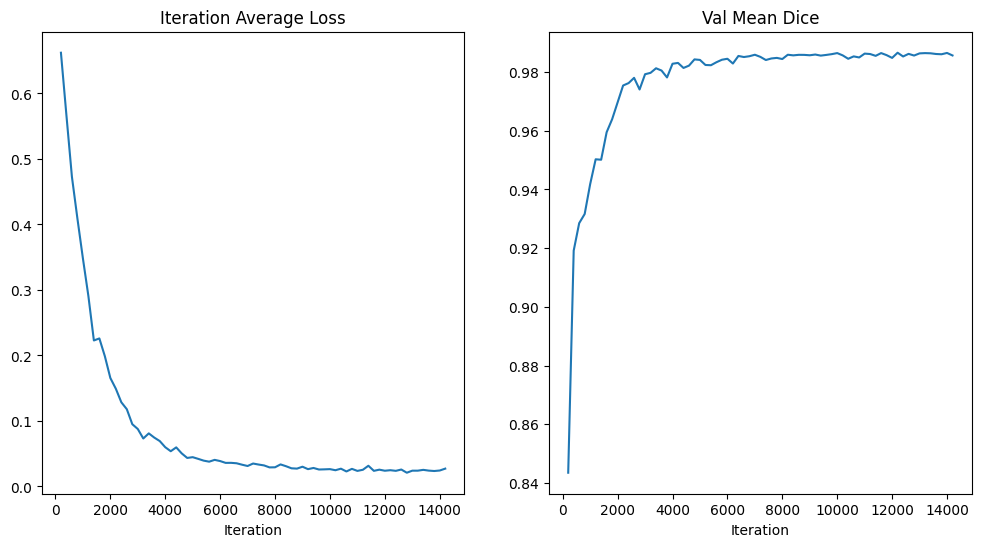

In [ ]:
# plot loss

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values_att_unet_withaug))]
#CHANGE PER MODEL
y = epoch_loss_values_att_unet_withaug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(metric_values_att_unet_withaug))]
#CHANGE PER MODEL
y = metric_values_att_unet_withaug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

# Save the metric values and epoch loss values to separate files
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "metric_values_att_unet_withaug.npy")), np.array(metric_values_att_unet_withaug))
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "epoch_loss_values_att_unet_withaug.npy")), np.array(epoch_loss_values_att_unet_withaug))

In [ ]:
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"att_unet_withaug_best_metric_model.pth")))
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"att_unet_withaug_best_metric_model.pth"))))

<All keys matched successfully>

In [ ]:
split_JSON_run = "face-training-1-lab-v1.json"


datasets_run = data_dir + split_JSON_run
val_files_run = load_decathlon_datalist(datasets_run, True, "validation")
val_ds_run = CacheDataset(
    data=val_files_run, transform=val_transforms, cache_num=300, cache_rate=1.0, num_workers=4
)
val_loader_run = DataLoader(
    val_ds_run, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 12/12 [00:00<00:00, 29.56it/s]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"att_unet_withaug_best_metric_model.pth"))), strict=False)
model.eval()

AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          )
          (1): BatchNorm3d(16, eps=1e-

0 261-img.nii.gz


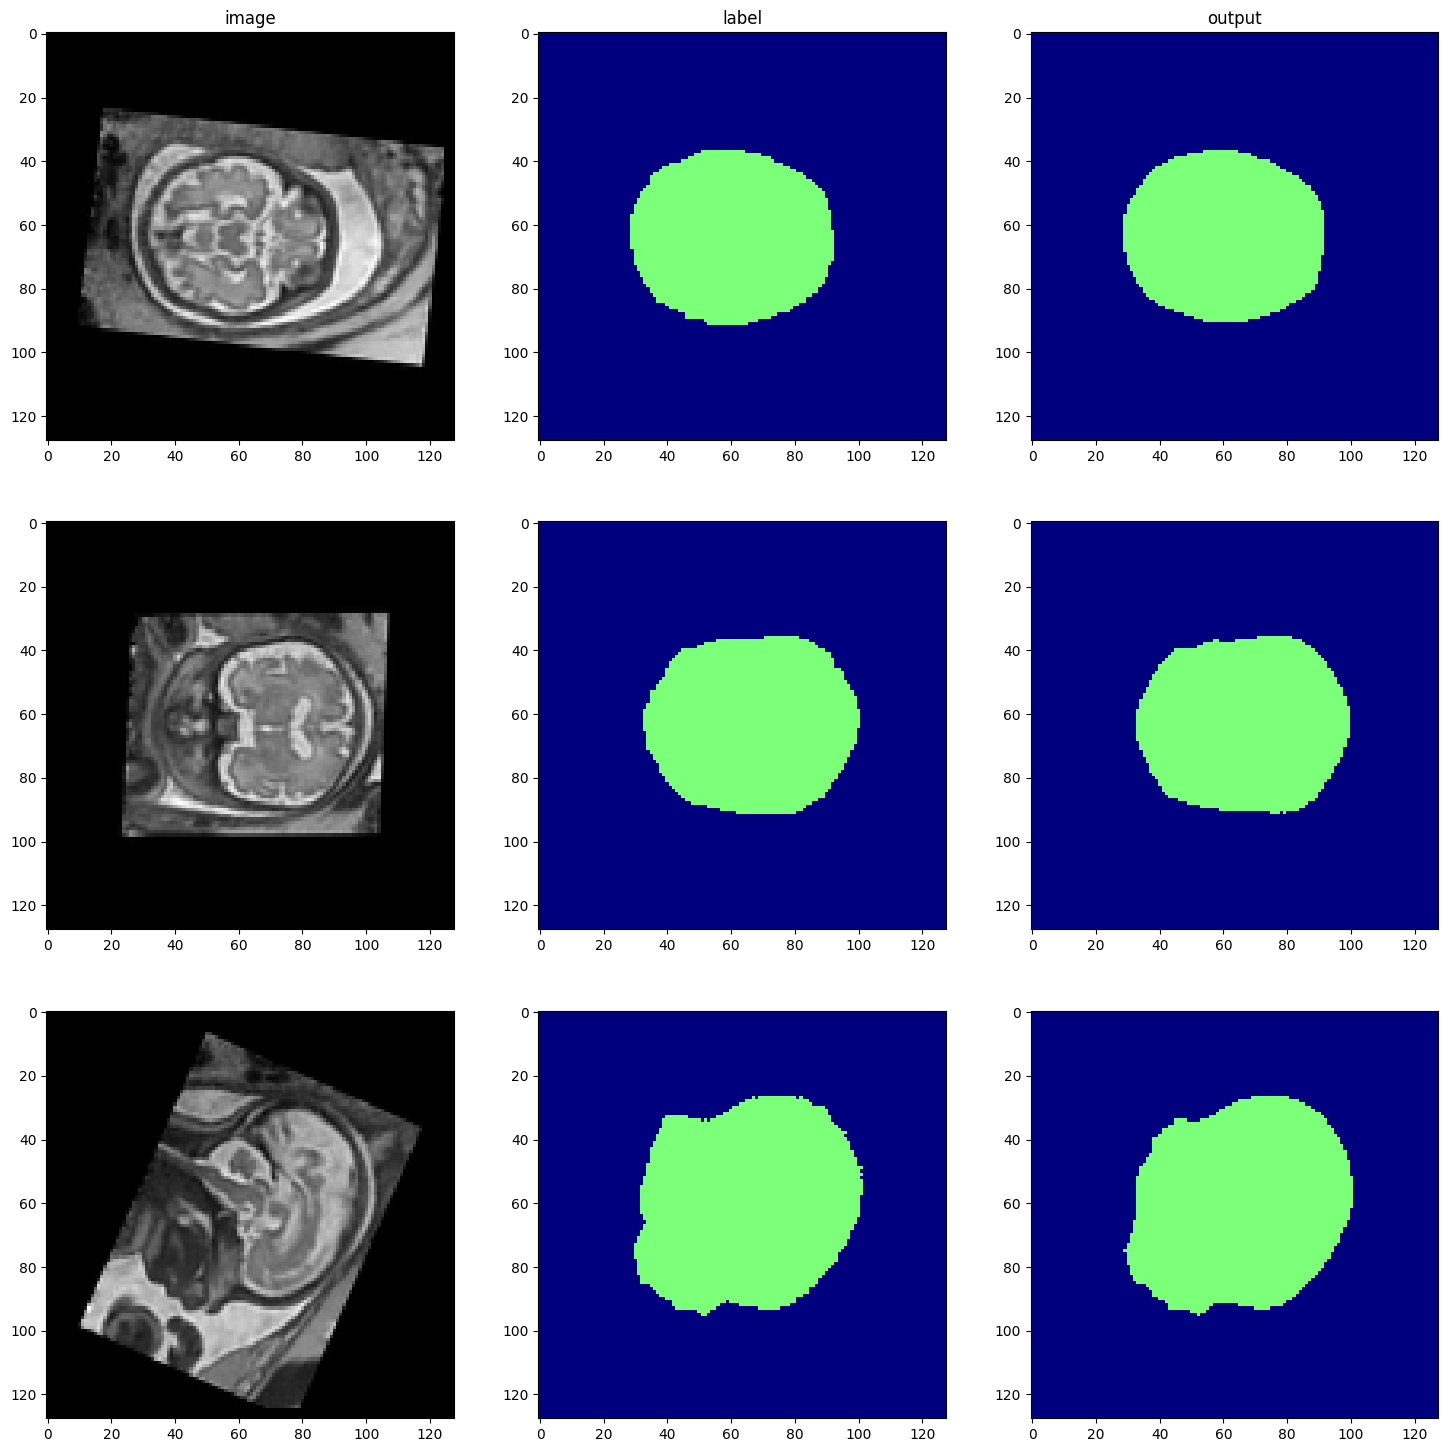

1 335-img.nii.gz


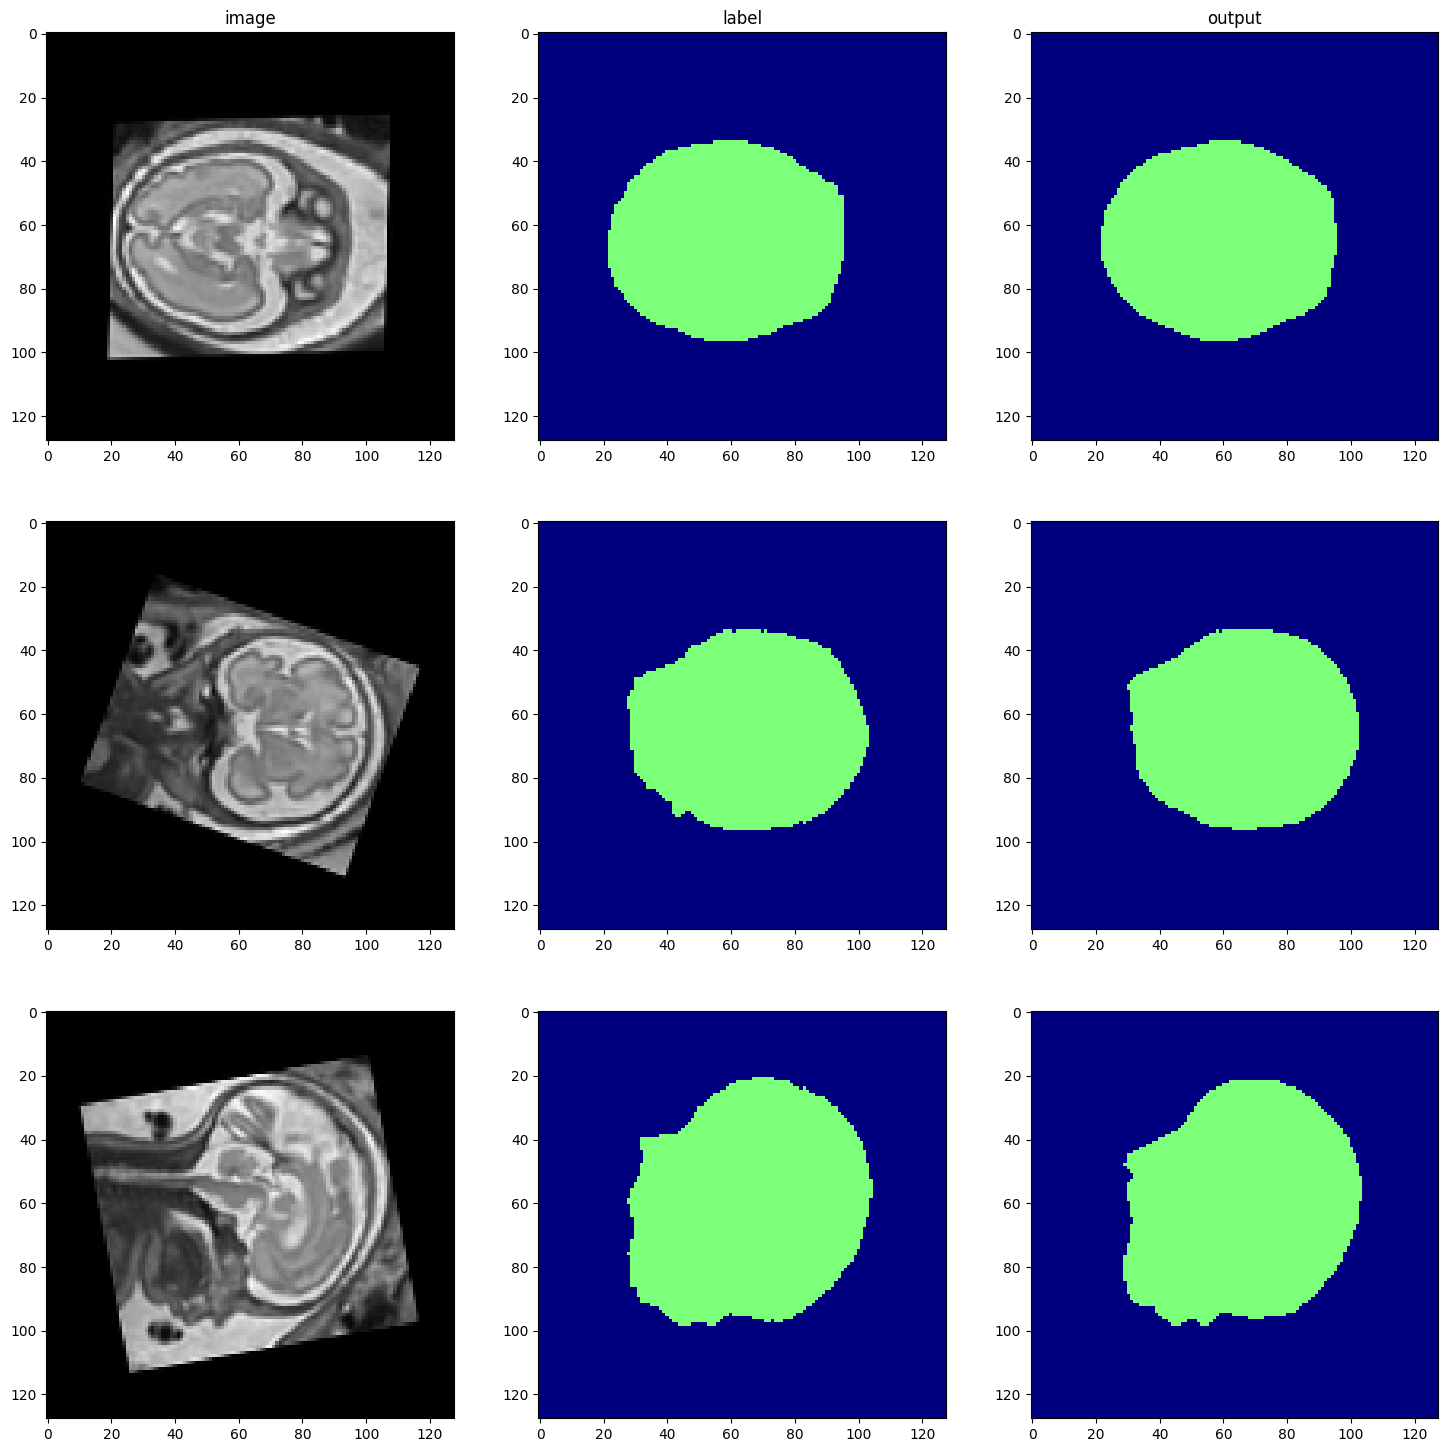

2 426-img.nii.gz


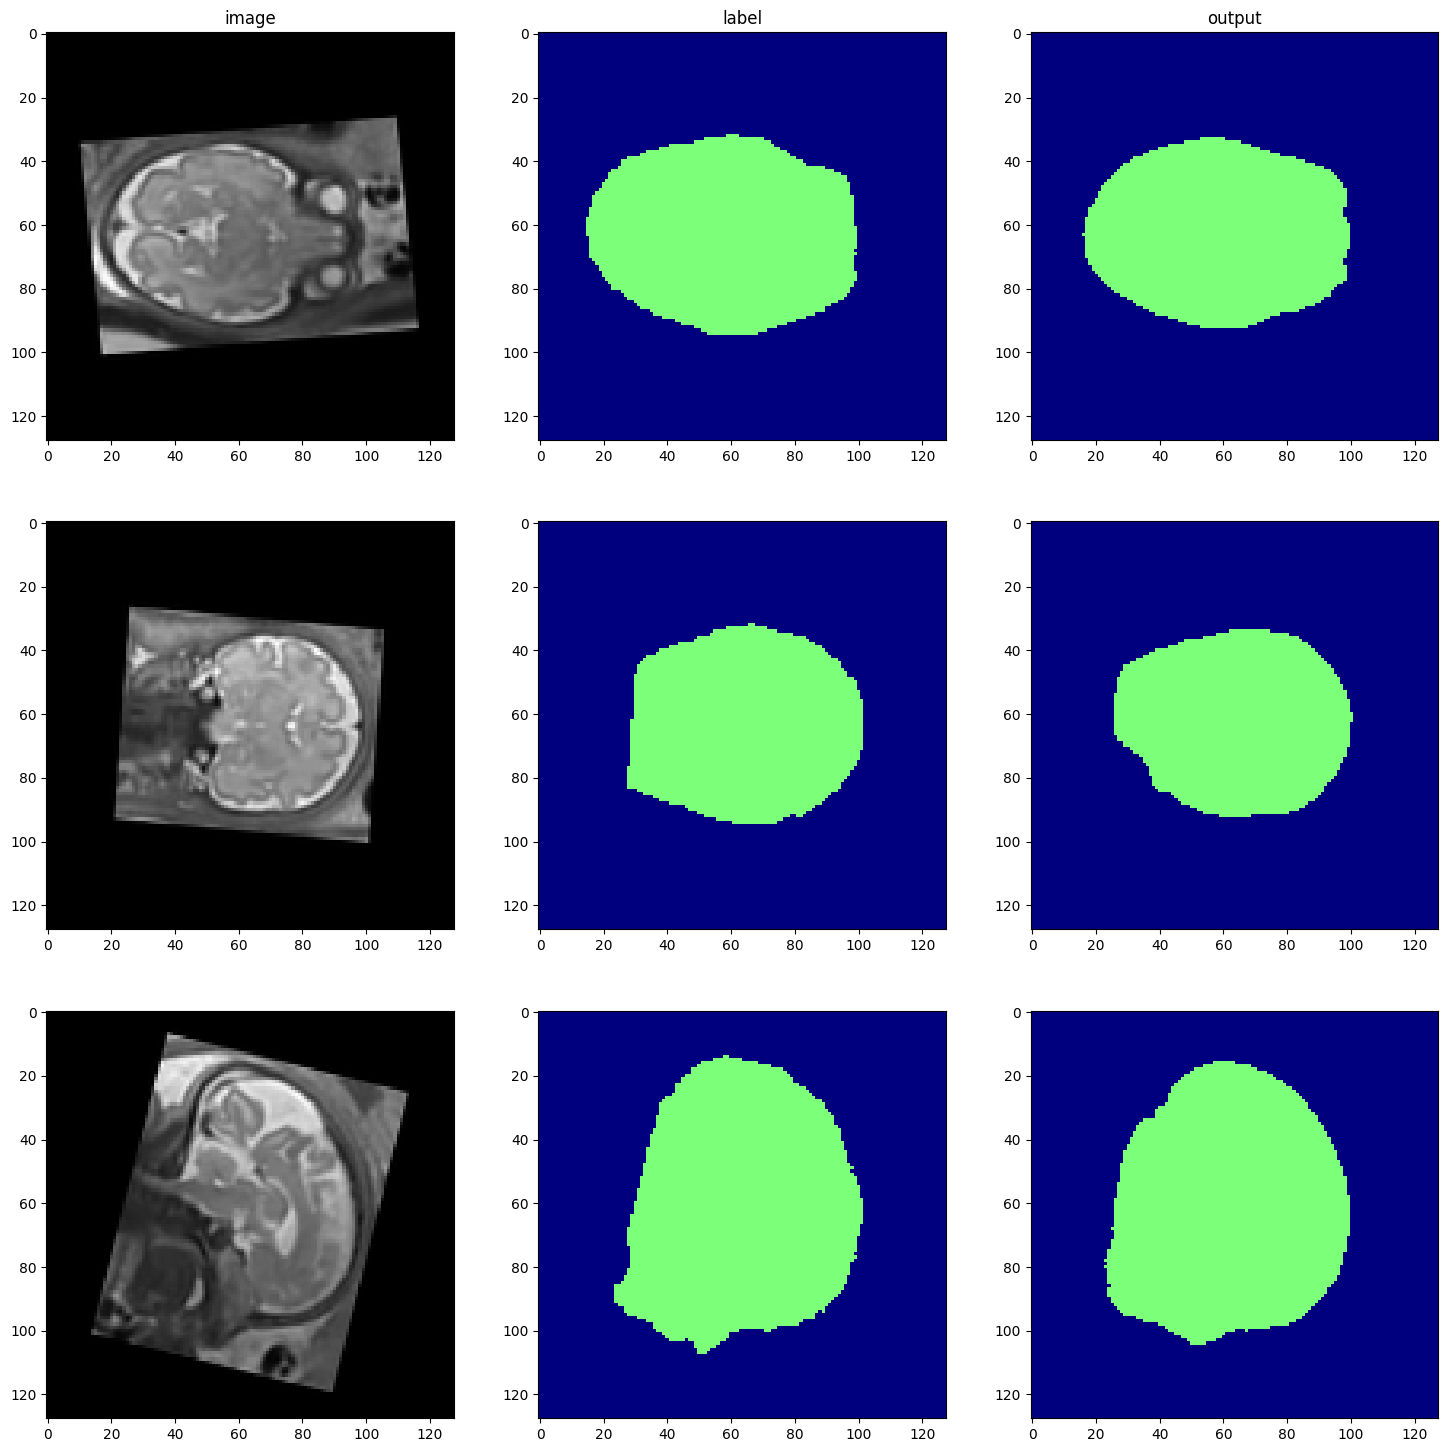

3 342-img.nii.gz


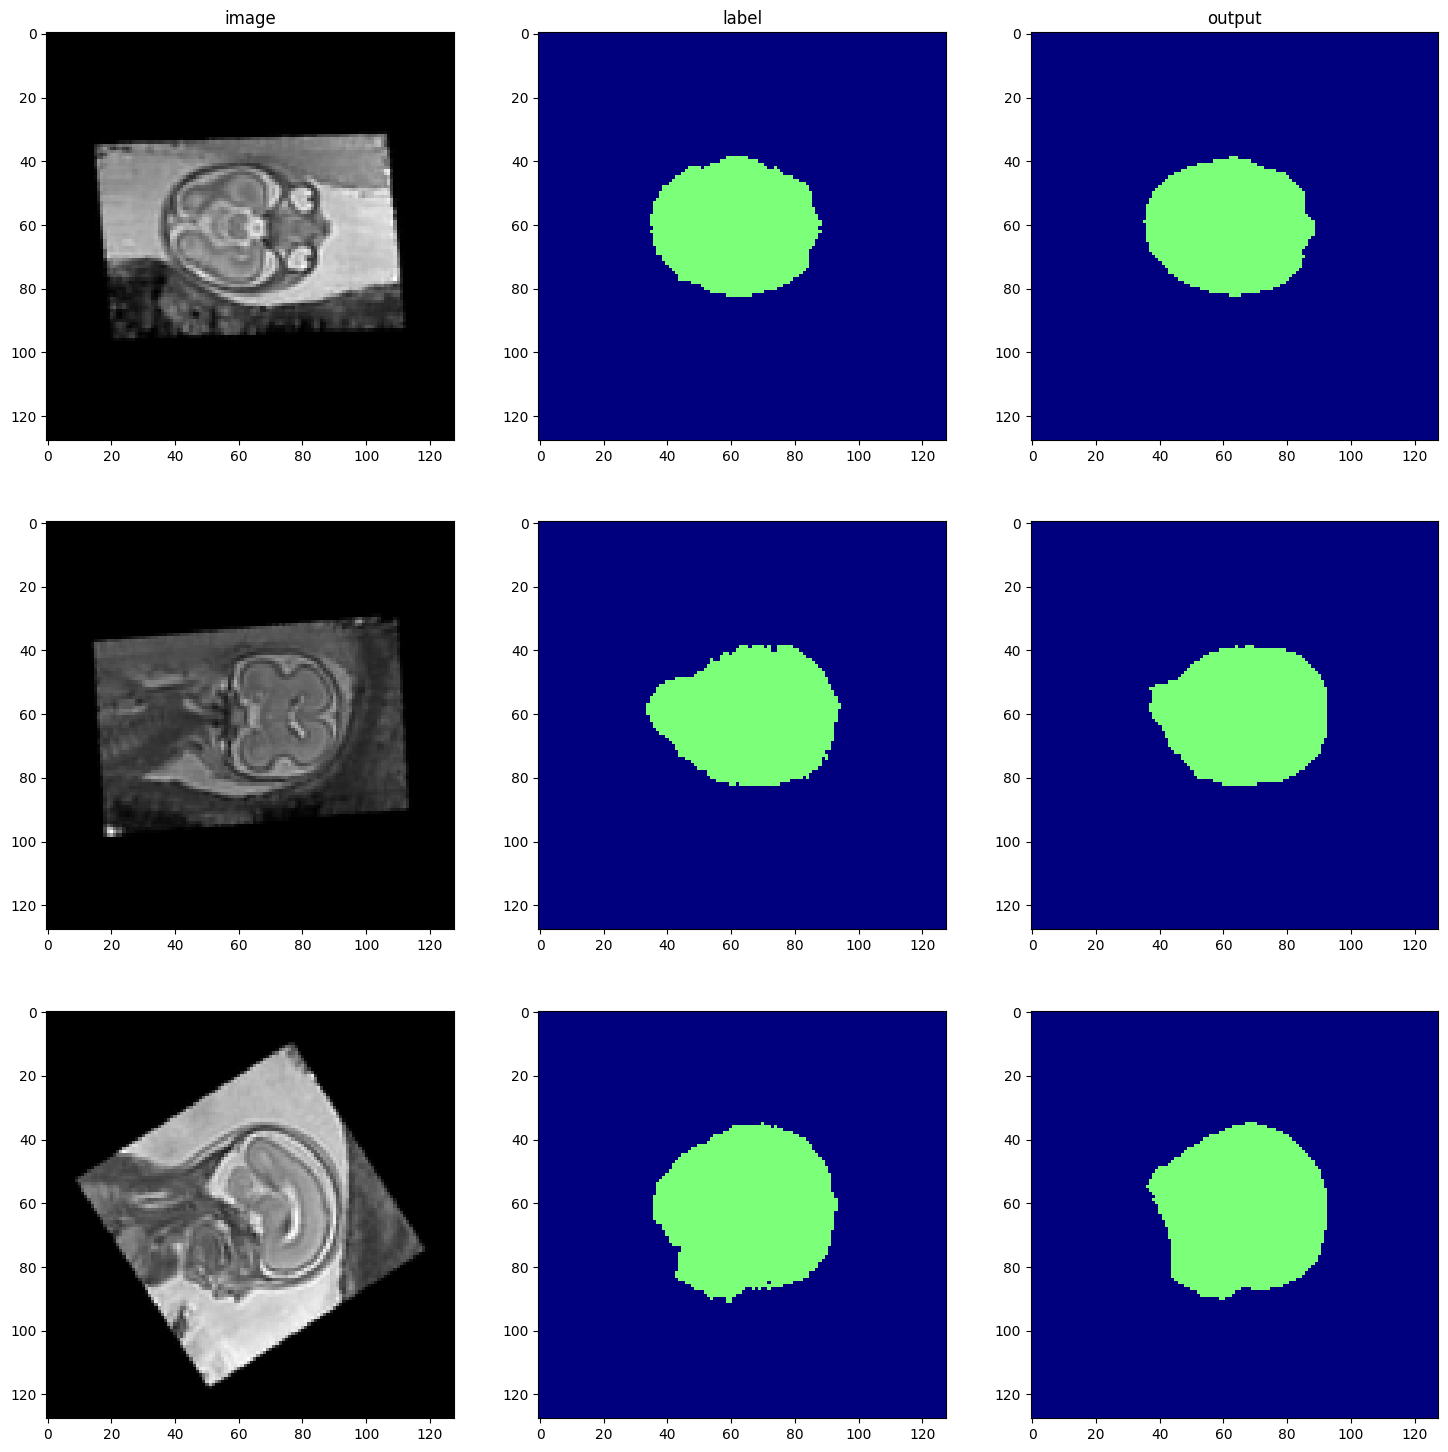

4 435-img.nii.gz


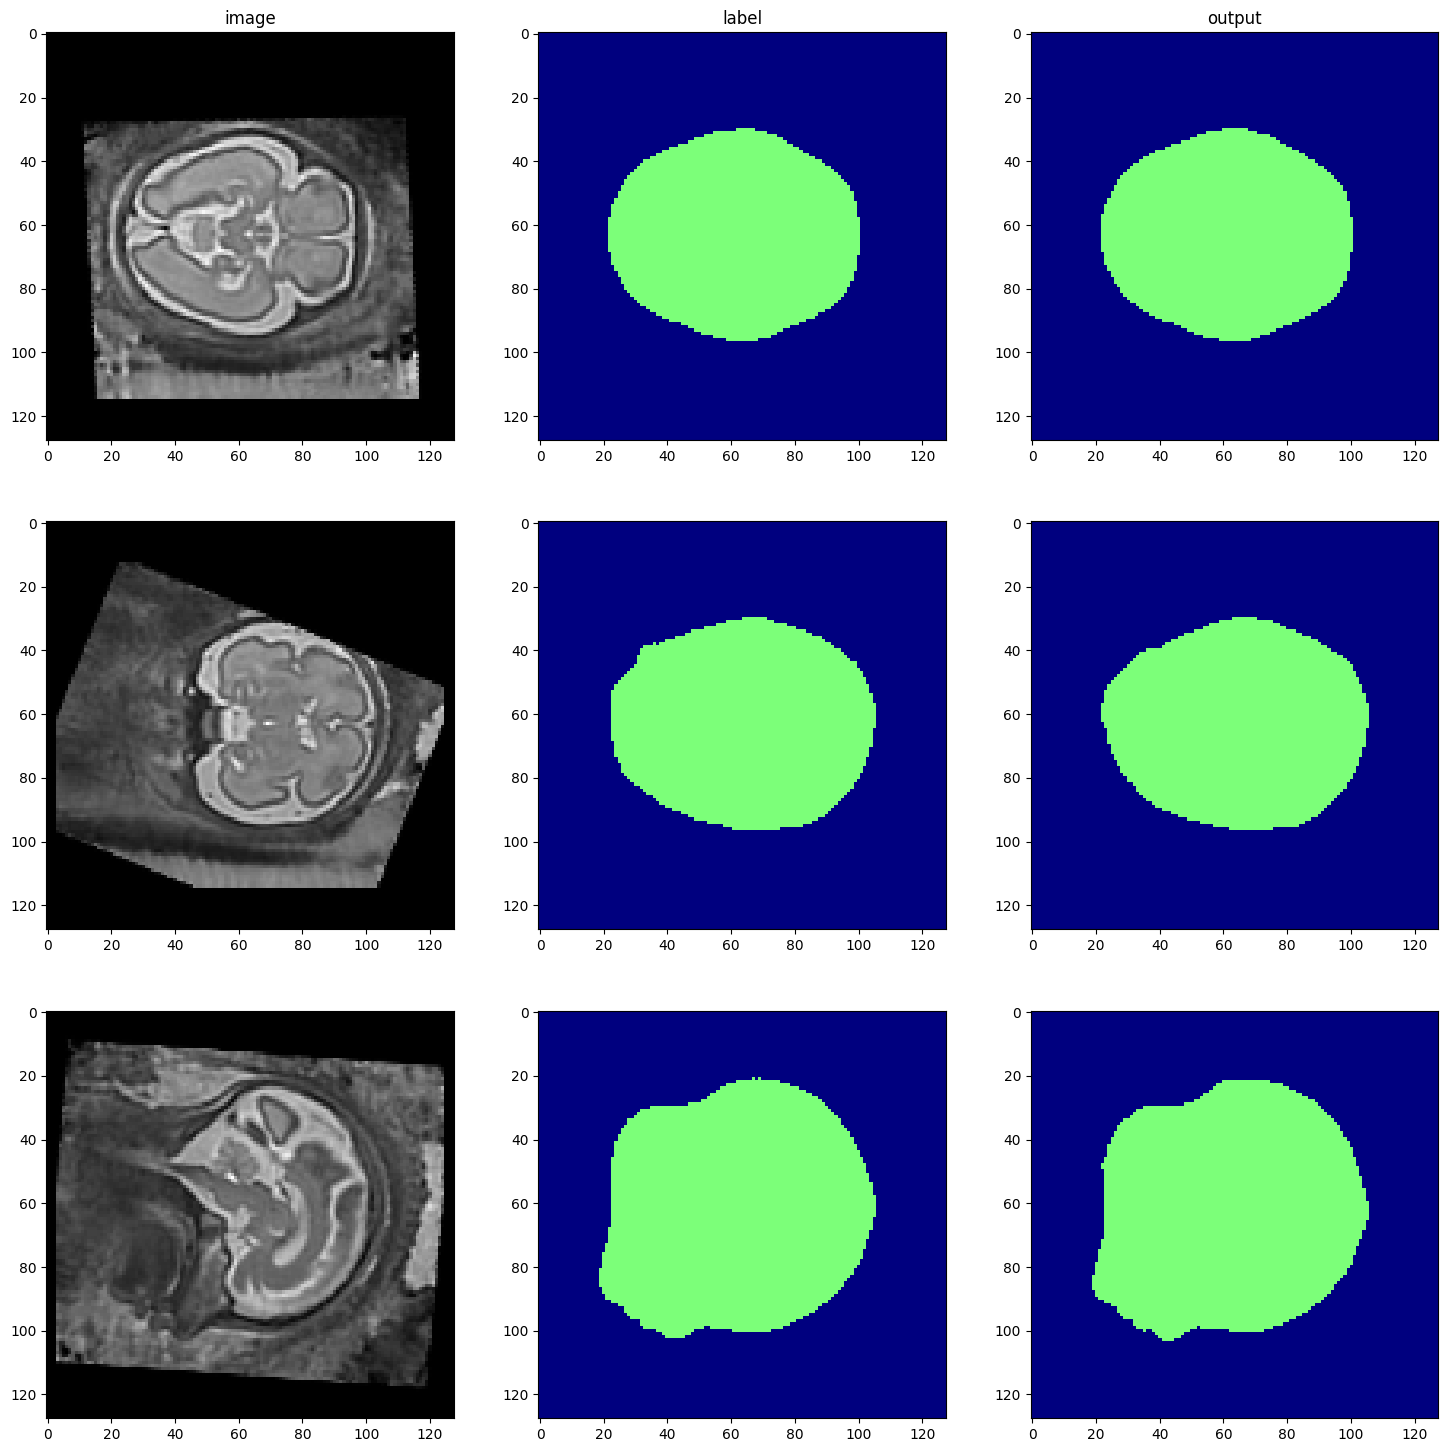

5 hist-136-img.nii.gz


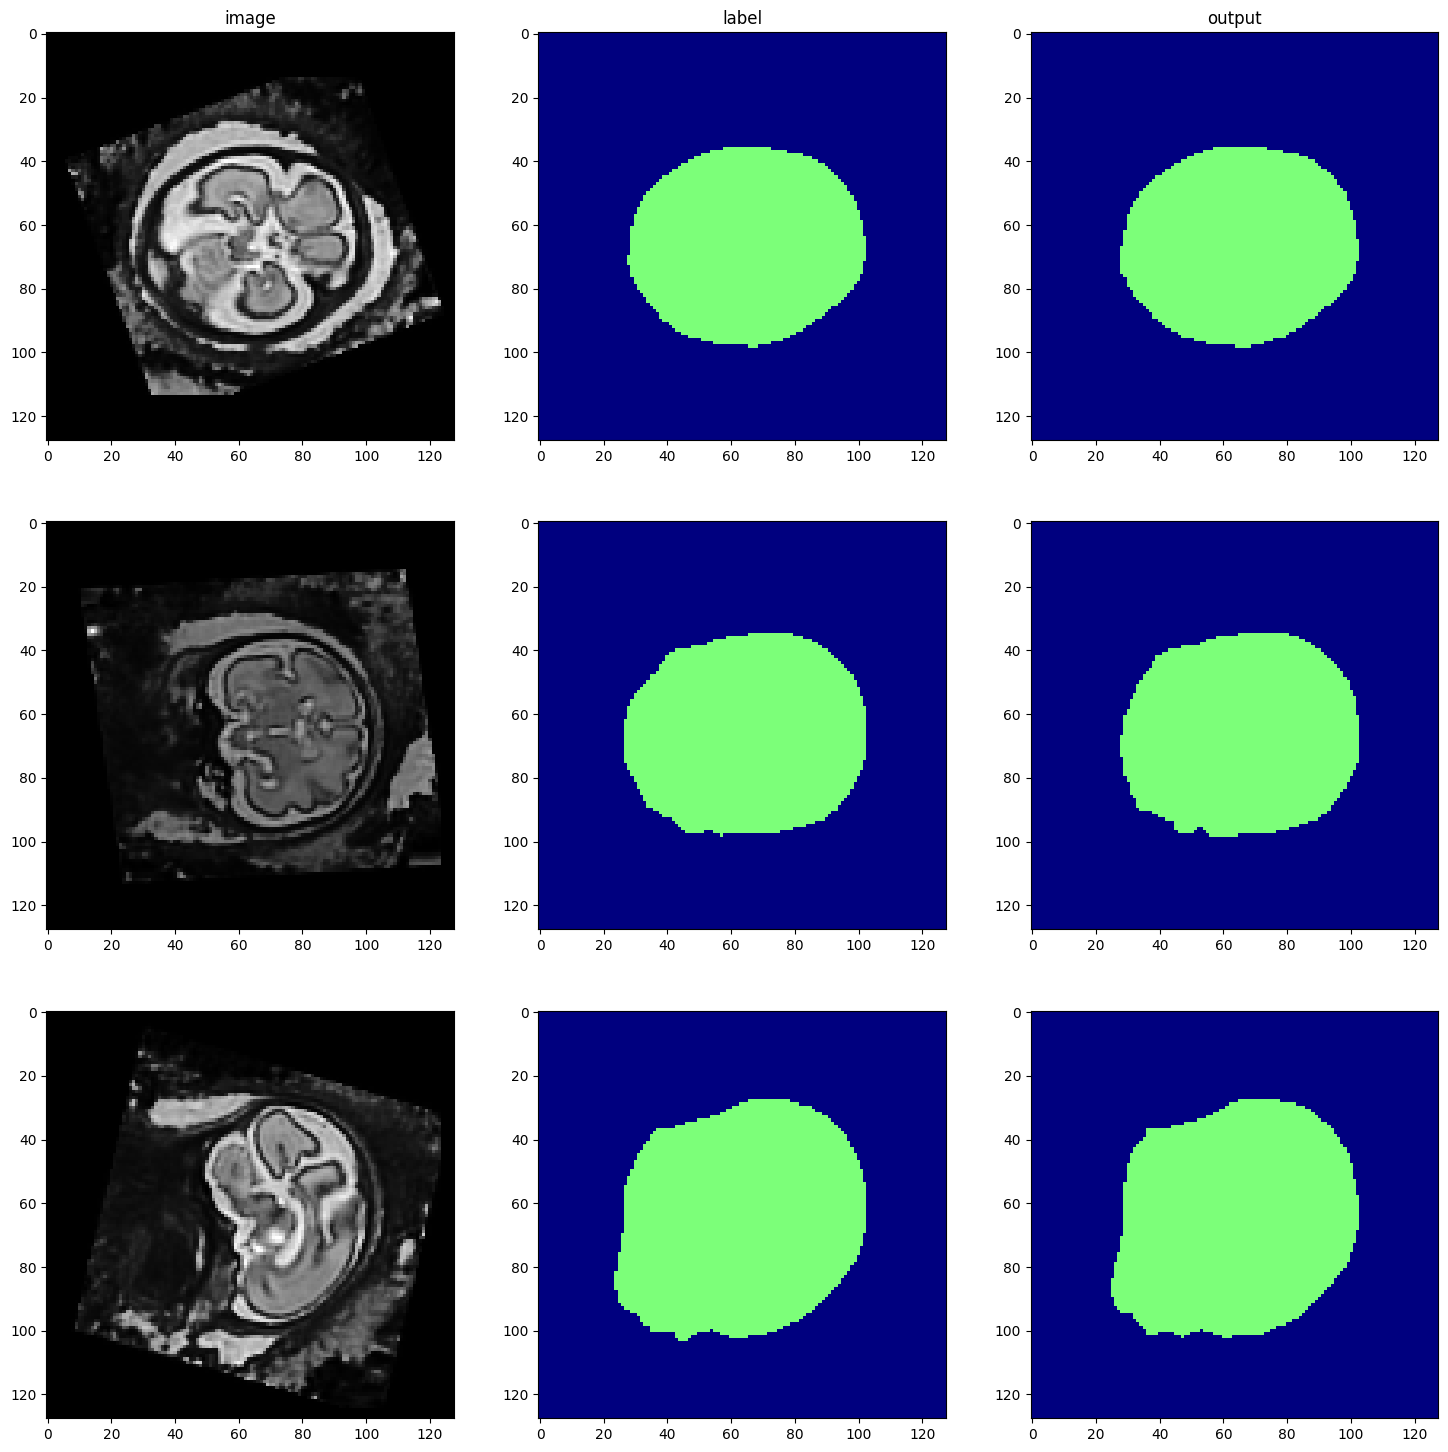

6 hist-214-img.nii.gz


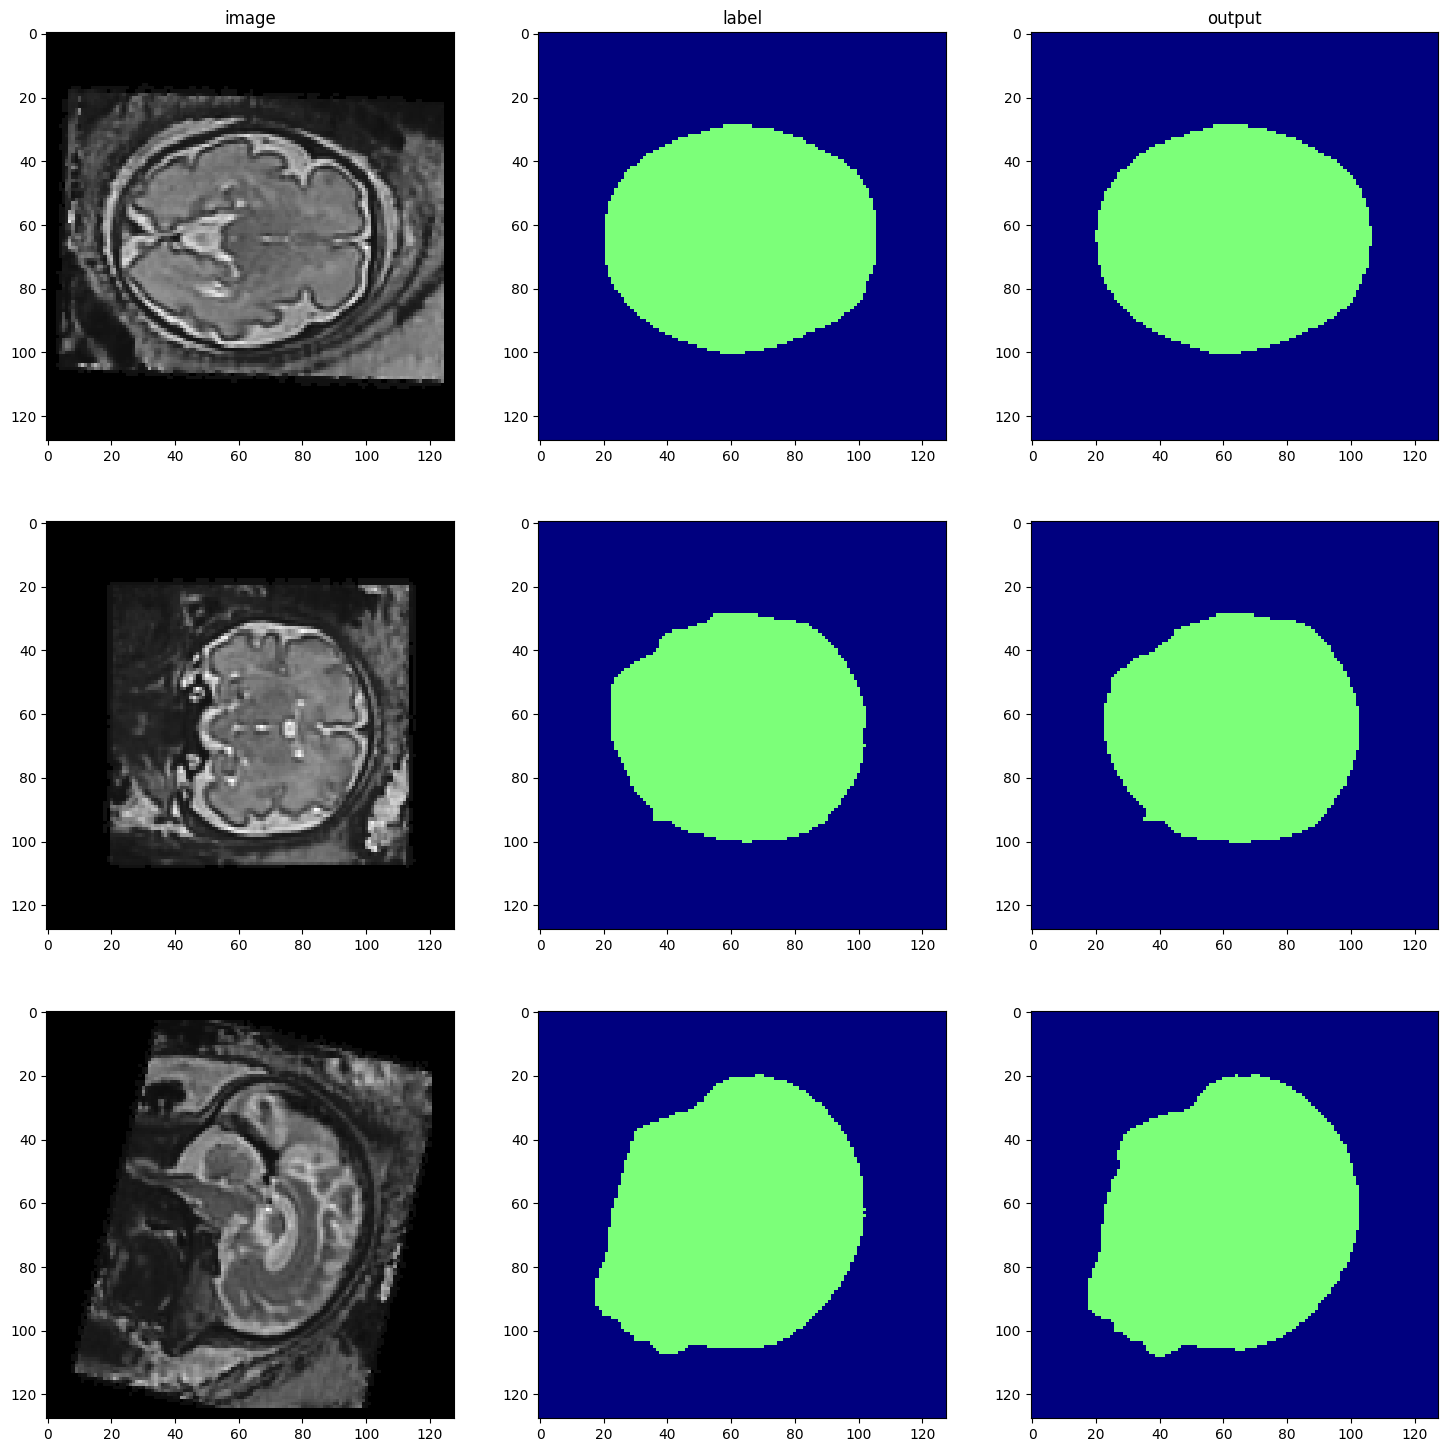

7 hist-236-img.nii.gz


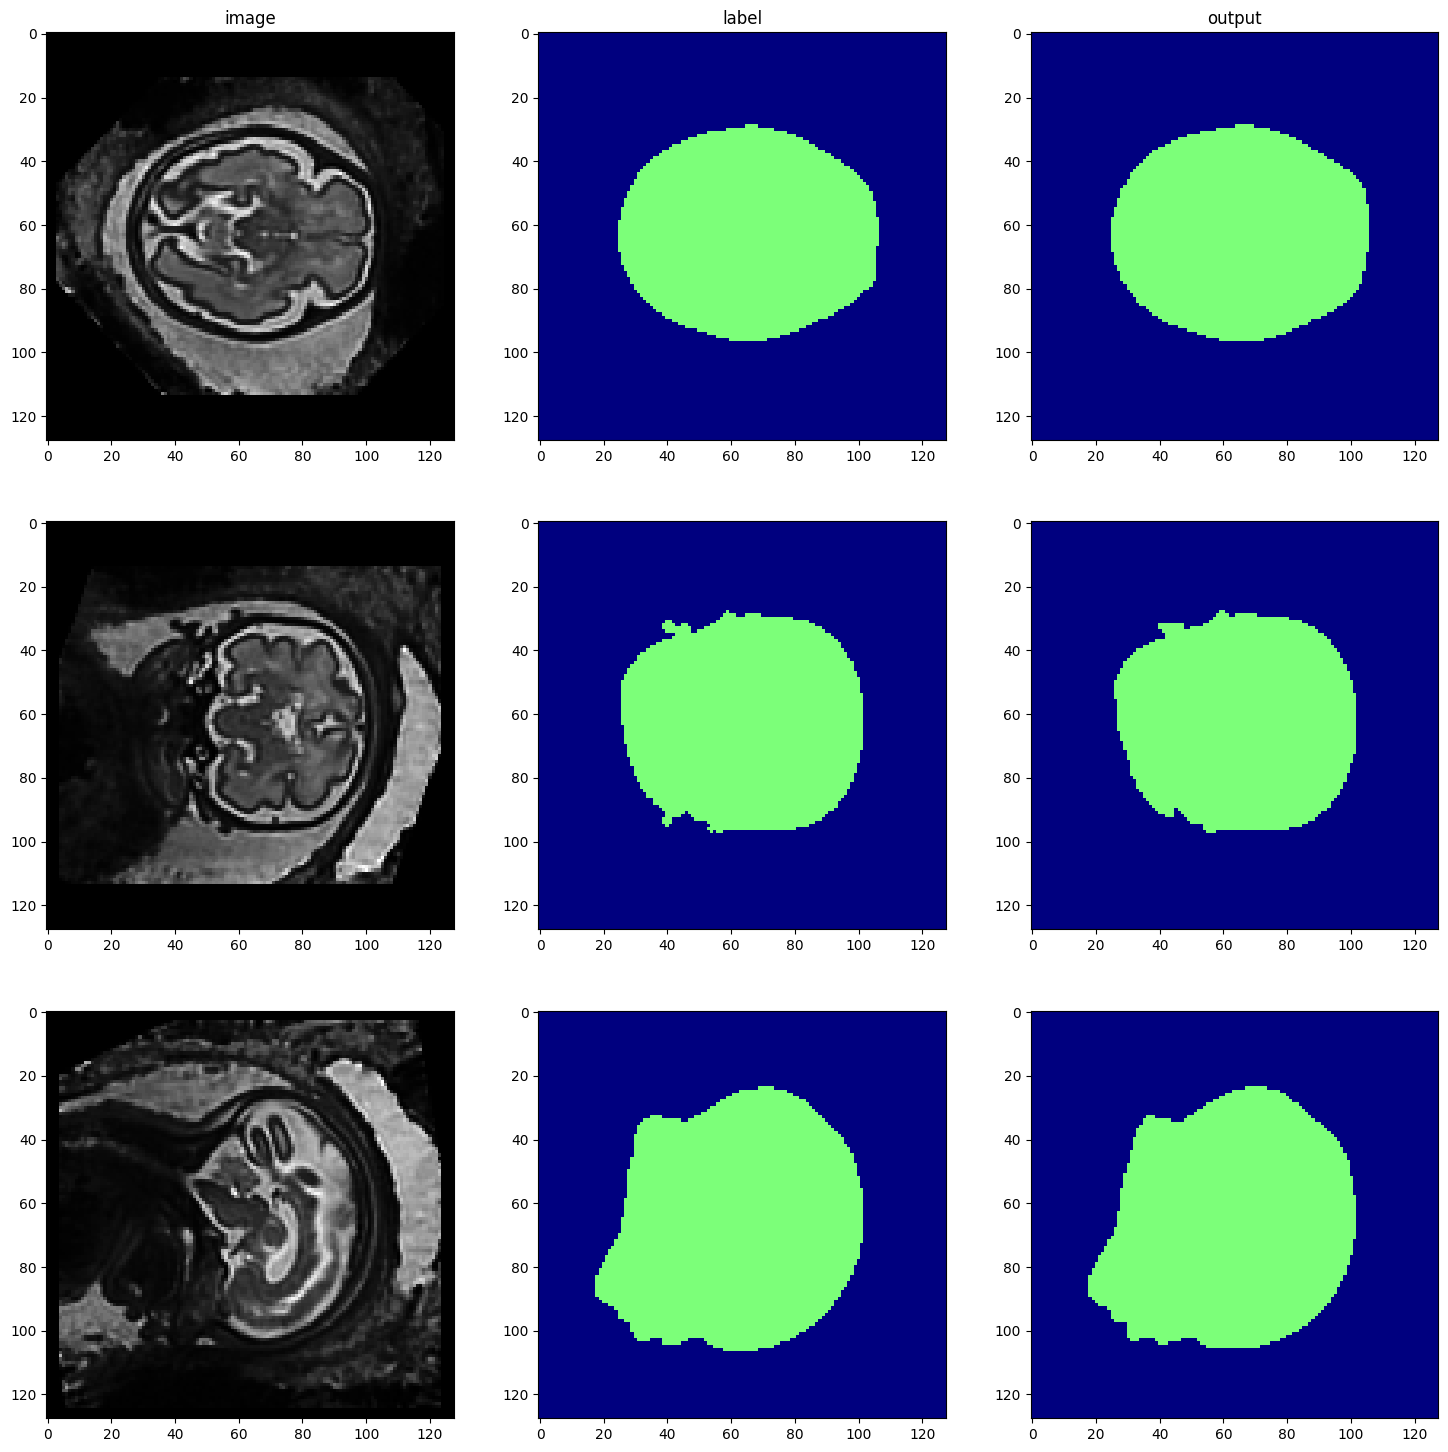

8 hist-253-img.nii.gz


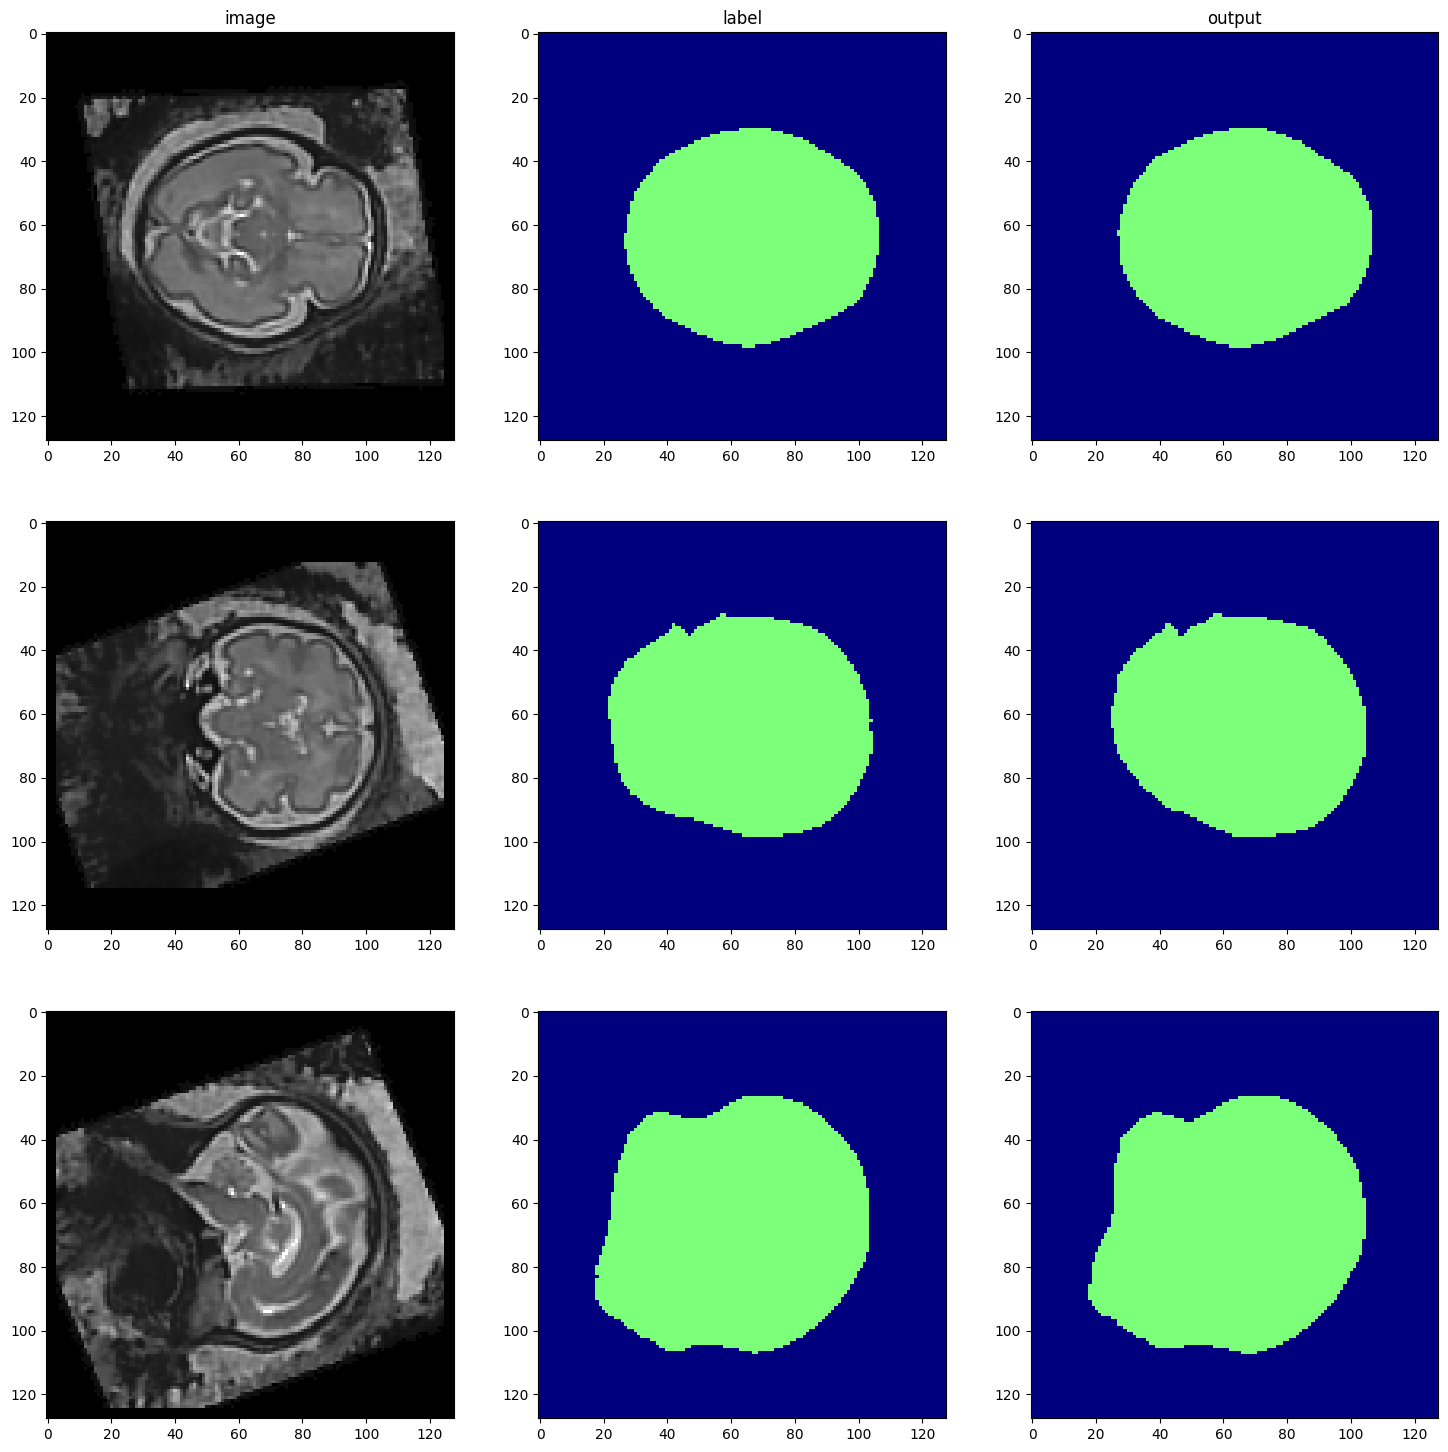

9 hist-275-img.nii.gz


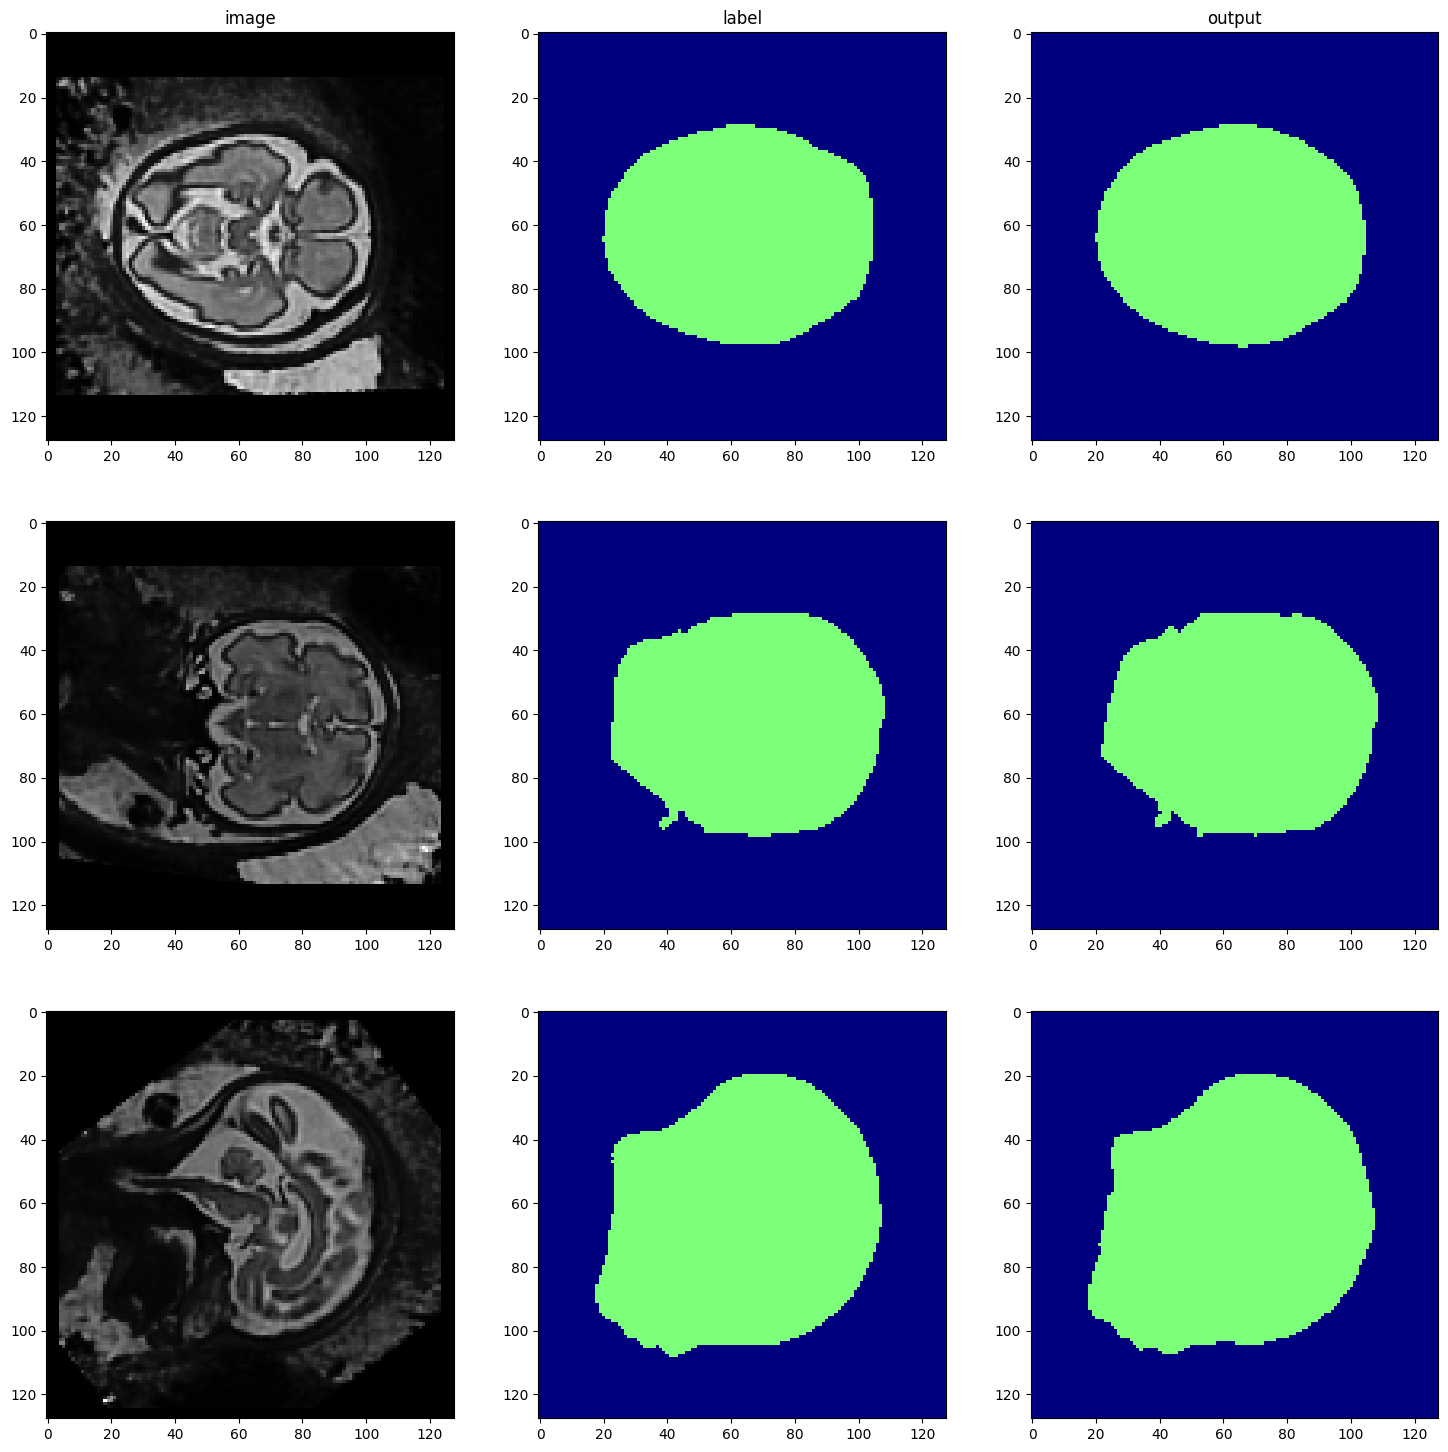

10 hist-292-img.nii.gz


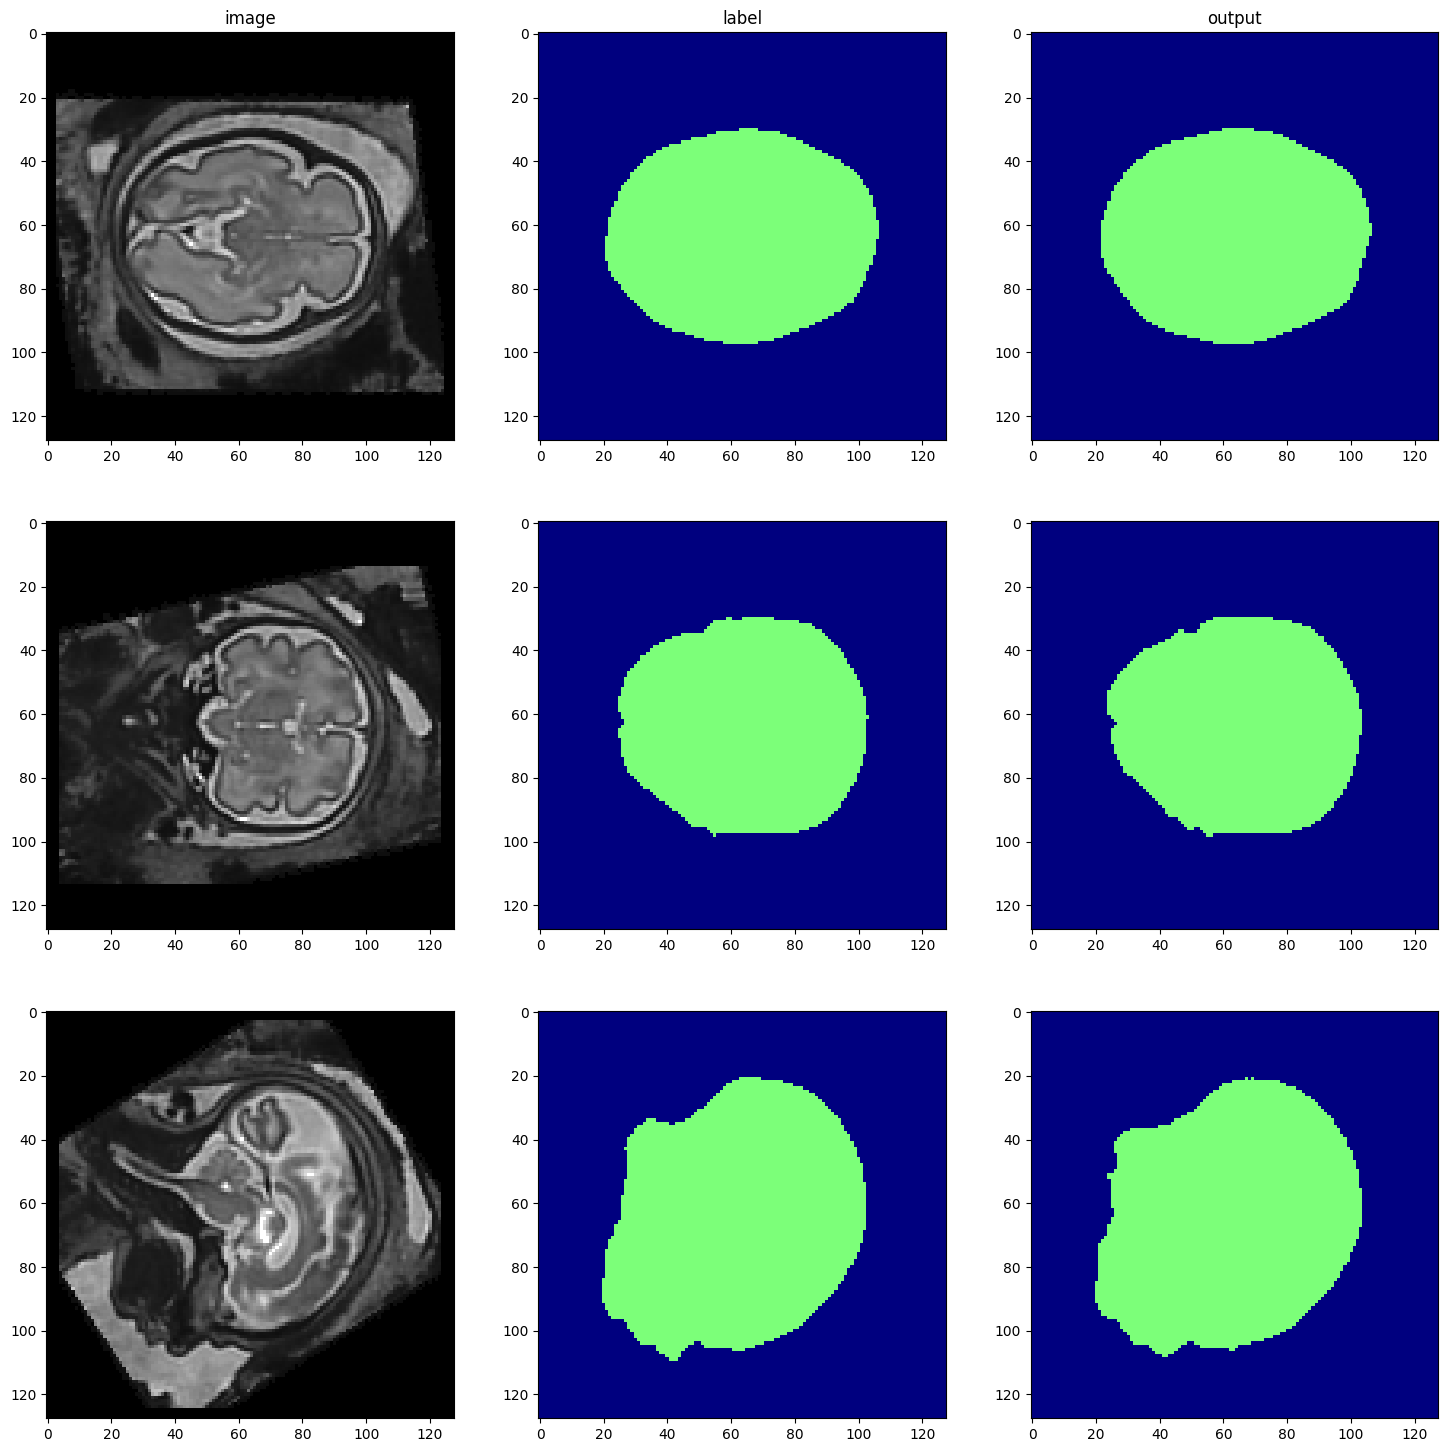

11 hist-355-img.nii.gz


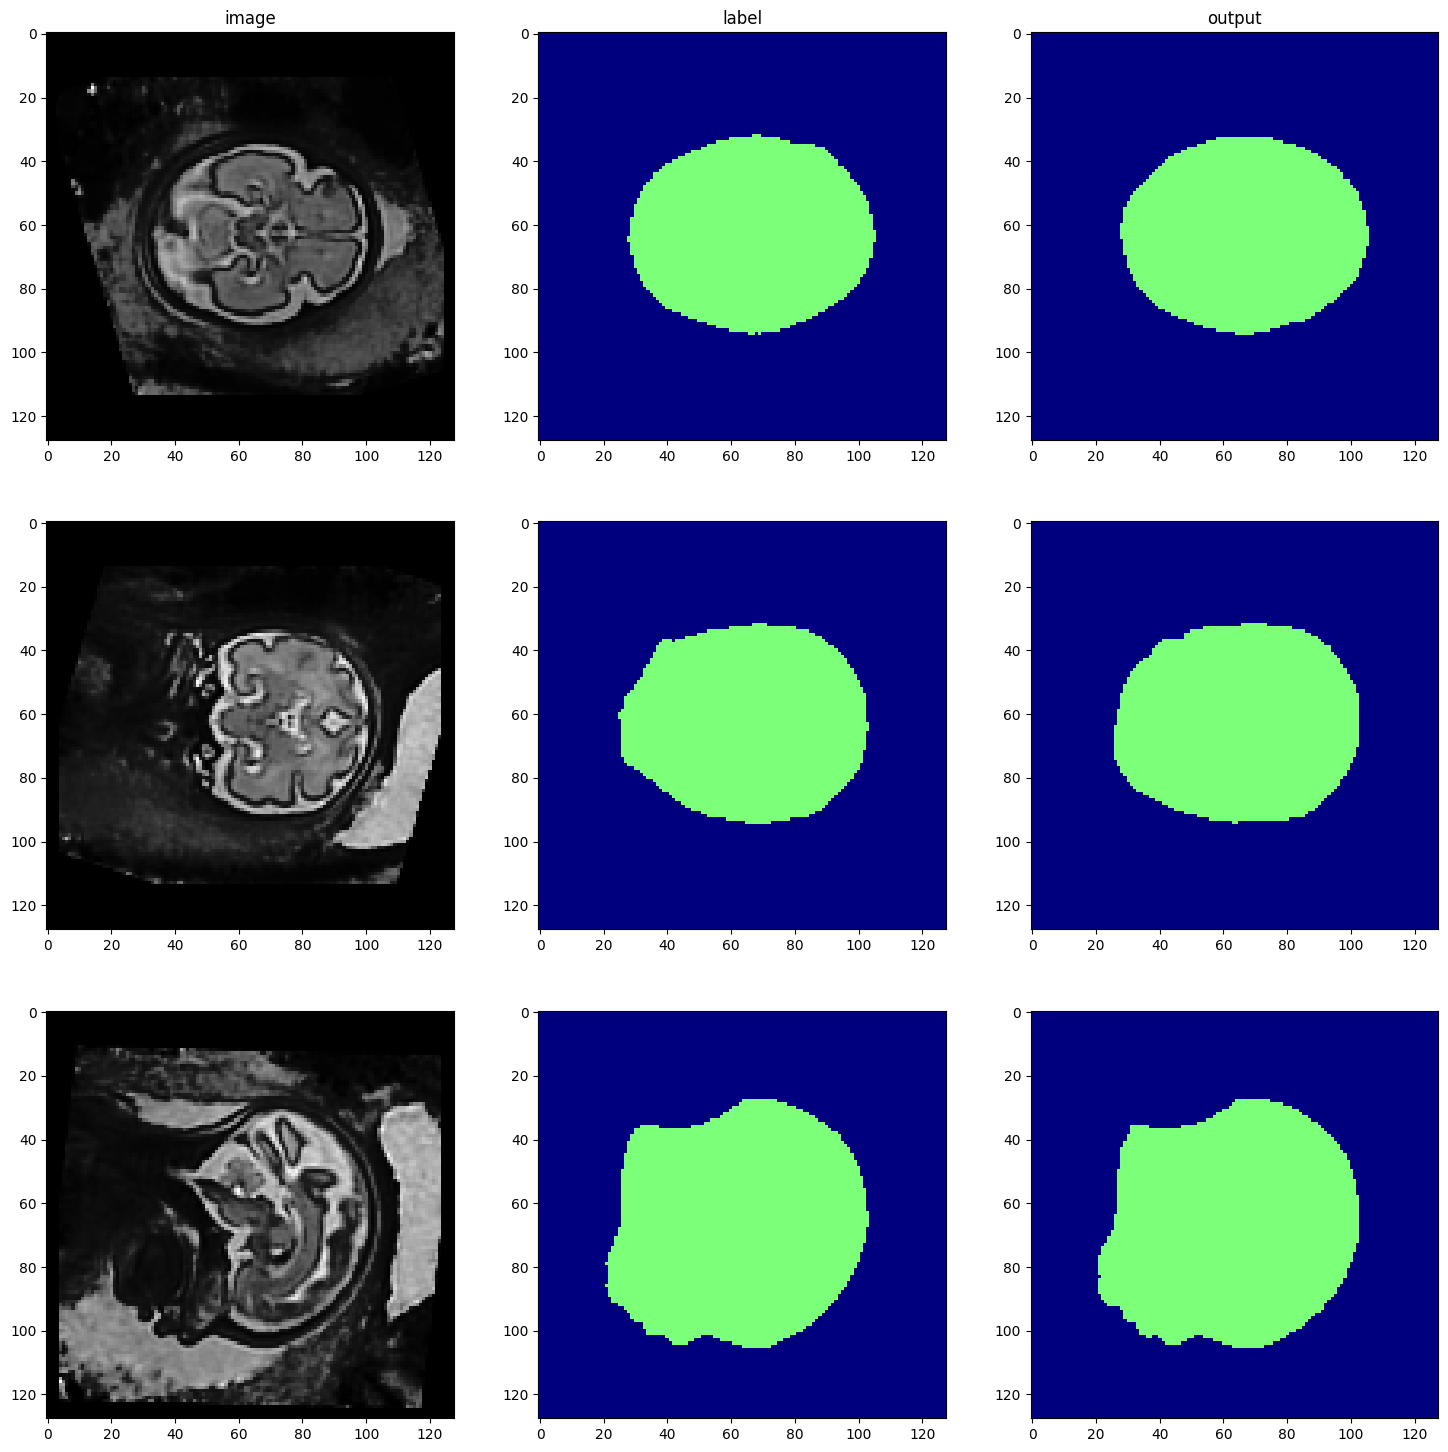

In [ ]:
class_n = class_num
qq=round(img_dim/2)

for x in range(len(val_files_run)):

  case_num = x
  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      cur_case = val_ds_run[case_num]
      img = cur_case["image"]
      label = cur_case["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      print(x,img_name)

      plt.figure("check", (18, 18))
      plt.subplot(3, 3, 1)
      plt.title("image")
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
      plt.subplot(3, 3, 2)
      plt.title("label")
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 3)
      plt.title("output")
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")

      plt.subplot(3, 3, 4)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
      plt.subplot(3, 3, 5)
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 6)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")


      plt.subplot(3, 3, 7)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
      plt.subplot(3, 3, 8)
      plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 9)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")

      plt.show()

In [ ]:
# save cnn segmentation results for all validation images


res_dir = root_dir + "/" + roi_type + "att_unet_withaug-results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


for x in range(len(val_files_run)):

  case_num = x
  img_name = val_files_run[case_num]["label"]
  label_name = val_files_run[case_num]["label"]
  case_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds_run[case_num]["image"]
      label = val_ds_run[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_att_unet_withaug-results/cnn-lab-261-img.nii.gz
1 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_att_unet_withaug-results/cnn-lab-335-img.nii.gz
2 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_att_unet_withaug-results/cnn-lab-426-img.nii.gz
3 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_att_unet_withaug-results/cnn-lab-342-img.nii.gz
4 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_att_unet_withaug-results/cnn-lab-435-img.nii.gz
5 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_att_unet_withaug-results/cnn-lab-hist-136-img.nii.gz
6 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_att_unet_withaug-results/cnn-lab-hist-214-img.nii.gz
7 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_att_unet_withaug-results/cnn-lab-hist-236-img.nii.gz
8 /content/drive/